In [1]:
from matplotlib import pyplot as plt
from collections import Counter
import numpy as np
import keras
import cv2

Using TensorFlow backend.


In [2]:
input_size = 160
n_classes = 4

In [3]:
def data2onehot(data):
    new_data = np.zeros((len(data), n_classes))
    new_data[np.arange(len(data)), data] = 1
    return new_data

def normalize(tensor):
    tensor -= tensor.min()
    return tensor/tensor.max()

def float2int(images):
    return (255*images).astype(np.uint8)

def int2float(images):
    return images.astype(float)/256

In [4]:
import os

class datasets:
    def load_data(path):
        X_data = list()
        Y_data = list()
        for folder in os.listdir(path):
            tmp = os.path.join(path, folder)
            if not os.path.isdir(tmp):
                continue
            x = [os.path.join(tmp, file) for file in os.listdir(tmp) if '.DS_Store' not in file]
            y = [folder]*len(x)
            X_data += x
            Y_data += y

        X_data = np.array(X_data)
        Y_data = np.array(Y_data)

        indexes = np.arange(X_data.shape[0])
        np.random.shuffle(indexes)
        return X_data[indexes], Y_data[indexes]
    
    def OCT():
        path = 'OCT2017'
        data2index = { 'CNV' : 0, 'DME' : 1, 'DRUSEN' : 2, 'NORMAL' : 3 }
        index2data = { 0 : 'CNV', 1 : 'DME', 2 : 'DRUSEN', 3 : 'NORMAL' }
        
        x_train, y_train = datasets.load_data(os.path.join(path, 'train'))
        x_test, y_test = datasets.load_data(os.path.join(path, 'test'))
        
        y_train = np.array([data2index[ii] for ii in y_train])
        y_test = np.array([data2index[ii] for ii in y_test])
        
        
        x_val = list()
        y_val = list()
        for c in range(n_classes):
            inds = np.where(y_train==c)[0]
            inds = inds[np.random.randint(len(inds), size=250)]
            
            x_val += list(x_train[inds])
            y_val += list(y_train[inds])
            x_train = np.delete(x_train, inds)
            y_train = np.delete(y_train, inds)
        x_val = np.array(x_val)
        y_val = np.array(y_val)
        
        y_train = data2onehot(y_train)
        y_val = data2onehot(y_val)
        y_test = data2onehot(y_test)
        
        return (x_train, y_train),(x_val, y_val), (x_test, y_test), (data2index, index2data)

In [5]:
train, val, test, (data2index, index2data) = datasets.OCT()
x_train, y_train = train
x_val, y_val = val
x_test, y_test = test

print('train len', x_train.shape, 'counter', Counter(y_train.argmax(1)))
print('test len', x_val.shape, 'counter', Counter(y_val.argmax(1)))
print('test len', x_test.shape, 'counter', Counter(y_test.argmax(1)))

train len (82493,) counter Counter({0: 36956, 3: 26065, 1: 11100, 2: 8372})
test len (1000,) counter Counter({0: 250, 1: 250, 2: 250, 3: 250})
test len (1000,) counter Counter({0: 250, 1: 250, 2: 250, 3: 250})


We can see that the train data is not uniformly distributed.
We need to make sure to insert the data uniformly to the model 
so it will not be biased later in favor for one class over the others.

In [6]:
def load_images(paths, dim3=False):
    if type(paths)==str or type(paths)==np.str or type(paths)==np.str_:
        return load_images([paths], dim3)[0]
        
    imgs = list()
    for path in paths:
        img = plt.imread(path)
        scale = min(input_size / img.shape[0], input_size / img.shape[1])
        height = min(input_size, int(scale * img.shape[1]))
        width = min(input_size, int(scale * img.shape[0]))
        img = cv2.resize(img, (height, width))
        
        backround = np.zeros((input_size, input_size), dtype=np.uint8)
        x = (input_size - img.shape[1])//2
        y = (input_size - img.shape[0])//2
        backround[y: y + img.shape[0], x: x + img.shape[1]] = img
        imgs.append(backround)
        
    imgs = np.array(imgs)
    if dim3:
        imgs = imgs.reshape((*imgs.shape, 1))
    return imgs

The method load's images from their path and automaticly resize them to the input size.
The method also has an option to add the third dimension if nedded (EX: Images that go inside the model)

In [7]:
from imgaug import augmenters as iaa
aug = iaa.Sometimes(0.5, [
  iaa.SomeOf((1,3), [
        iaa.OneOf([
            iaa.SaltAndPepper(p=(0, 0.1)), 
            iaa.AdditiveGaussianNoise(scale=(5,20)),
            iaa.Multiply((0.75, 1.5)),
            iaa.Add((-25, 25))
        ]),
        iaa.OneOf([
            iaa.MedianBlur(k=(3,7)),
            iaa.AverageBlur(k=(3,6)),
            iaa.GaussianBlur(sigma=(0,2))
        ]),
        iaa.OneOf([
            iaa.Emboss(alpha=(0.5,1), strength=(0.5,1)),
            iaa.Sharpen(alpha=(0.25,0.5), lightness=(0.25,0.5))
        ]),
        iaa.OneOf([
            iaa.CropAndPad((-100,100)),
            iaa.Affine(translate_percent={'x':(-0.1,0.1), 'y':(-0.1,0.1)})
        ]),
        iaa.OneOf([
            iaa.Affine(rotate=(-25,25)),
            iaa.Fliplr()
        ])
    ])  
])

The augmentations that will be later used, categorized by their functonlity (Noise, Blur, filters, movement and rotation).

In [8]:
from matplotlib import pyplot as plt
def data_generator(X, Y, batch_size, do_aug=False):
    X_tmp = [None] * n_classes
    Y_tmp = [None] * n_classes
    for c in range(n_classes):
        inds = (Y.argmax(1)==c)
        X_tmp[c] = X[inds]
        Y_tmp[c] = Y[inds]
    X = X_tmp
    Y = Y_tmp
    
    while True:
        imgs_path = list()
        labels = list()
        for c in range(n_classes):
            idx = np.random.randint(0, len(X[c]), (batch_size//n_classes))
            imgs_path += X[c][idx].tolist()
            labels += Y[c][idx].tolist()
        
        imgs = load_images(imgs_path)
        if do_aug:
            imgs = aug.augment_images(imgs)
        
        imgs = imgs.reshape((*imgs.shape, 1))
        labels = np.array(labels)
        
        inds = np.arange(len(imgs))
        np.random.shuffle(inds)
        
        yield int2float(imgs[inds]), labels[inds]

The data genrator designed to yield the data uniformly distributed for the model.
It can be seen in the example bellow that in batch of 4000 images there are exacly 1000 of each class

In [9]:
gen = data_generator(x_train, y_train, batch_size=4000)
x, y = next(gen)
print(Counter(y.argmax(1)))

Counter({0: 1000, 1: 1000, 2: 1000, 3: 1000})


Below is a visualization of the images to get a sense of the data we are working with

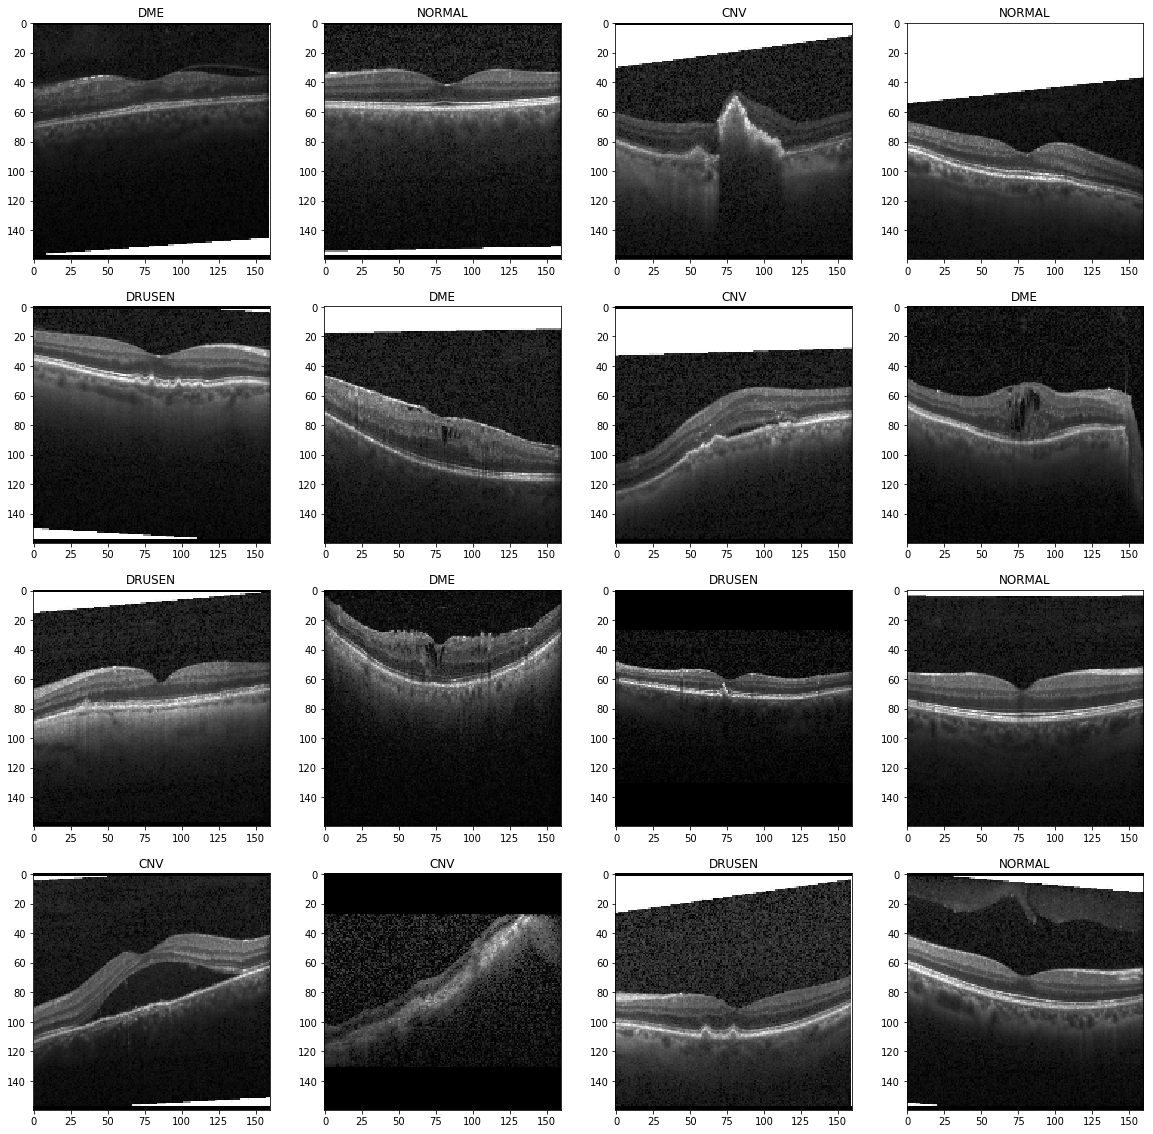

In [10]:
gen = data_generator(x_train, y_train, batch_size=16)
x,y = next(gen)
plt.figure(figsize=[20,20])
for img, label, index in zip(x,y, range(x.shape[0])):
    plt.subplot(4,4,index+1)
    plt.imshow(img[:,:,0], cmap='gray')
    plt.title(index2data[label.argmax()])
plt.show()

Below is a visualization of the images with augmentations to realize if the augmentations are good for the data and not ruins it.

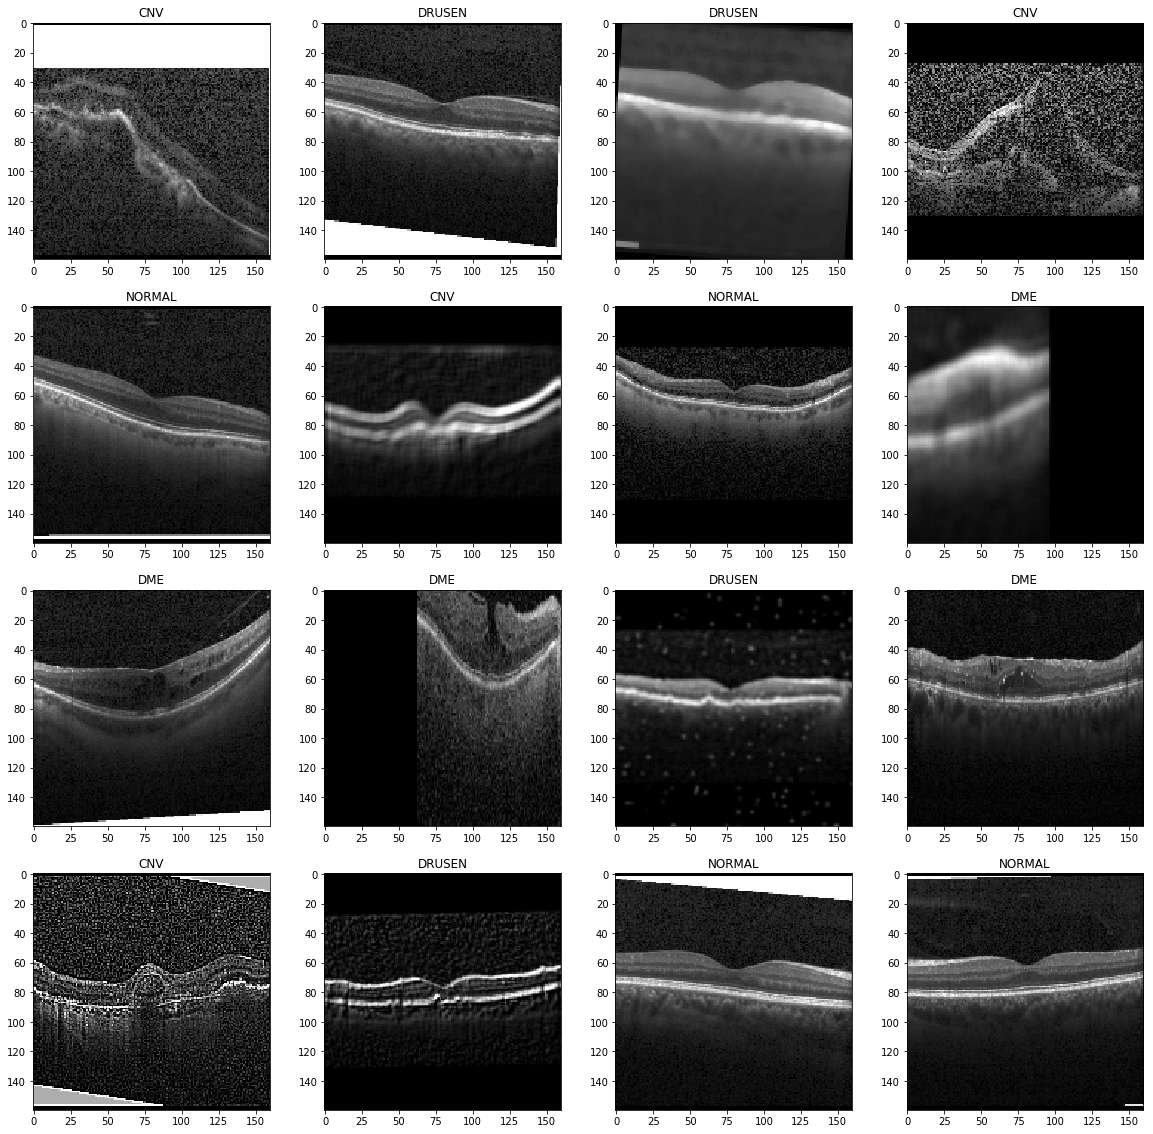

In [11]:
gen = data_generator(x_train, y_train, batch_size=16, do_aug=True)
x,y = next(gen)
plt.figure(figsize=[20,20])
for img, label, index in zip(x,y, range(x.shape[0])):
    plt.subplot(4,4,index+1)
    plt.imshow(img[:,:,0], cmap='gray')
    plt.title(index2data[label.argmax()])
plt.show()

Except only a few images that got to much augmented the reults are good. I prefer to leave it like that and not lower
The amount of augmentations because the model might still extract data from it that I can't see with my eyes.

In [12]:
from keras.models import Model
from keras.applications.mobilenet import MobileNet

In [13]:
oct_model = MobileNet(include_top=True, weights=None, input_shape=(input_size, input_size, 1), classes=n_classes)
oct_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 160, 160, 1)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 161, 161, 1)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 80, 80, 32)        288       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 80, 80, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 80, 80, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 80, 80, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 80, 80, 32)        128       
__________

I used mobilenet because I ran the model on my own laptop and it can't handle big models.
I couldn't use google colab because the data it too large (5.5G).
Could be that with more robust model I could have got a better result.

For start I desided to run the model without augmentations so it could learn faster at start.

In [14]:
from keras.callbacks import EarlyStopping

x_val_imgs = int2float(load_images(x_val, dim3=True))
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose = 1, restore_best_weights=True)
oct_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])

train = data_generator(x_train, y_train, 32, do_aug=False)

hist = oct_model.fit_generator(generator=train, epochs=100, steps_per_epoch=100, 
                               verbose=1, callbacks=[early_stopping],
                               validation_data=(x_val_imgs, y_val))

Epoch 1/100
100/100 [==============================] - 93s 926ms/step - loss: 1.3252 - acc: 0.3884 - val_loss: 2.7845 - val_acc: 0.3070
Epoch 2/100
100/100 [==============================] - 86s 857ms/step - loss: 1.0519 - acc: 0.5216 - val_loss: 2.7354 - val_acc: 0.3360
Epoch 3/100
100/100 [==============================] - 85s 851ms/step - loss: 0.9267 - acc: 0.6019 - val_loss: 1.7133 - val_acc: 0.4340
Epoch 4/100
100/100 [==============================] - 85s 855ms/step - loss: 0.8424 - acc: 0.6409 - val_loss: 2.9455 - val_acc: 0.2820
Epoch 5/100
100/100 [==============================] - 86s 857ms/step - loss: 0.7527 - acc: 0.6859 - val_loss: 1.4833 - val_acc: 0.4510
Epoch 6/100
100/100 [==============================] - 86s 855ms/step - loss: 0.7175 - acc: 0.7025 - val_loss: 6.9203 - val_acc: 0.2500
Epoch 7/100
100/100 [==============================] - 86s 860ms/step - loss: 0.6618 - acc: 0.7303 - val_loss: 0.9185 - val_acc: 0.6770
Epoch 8/100
100/100 [===========================

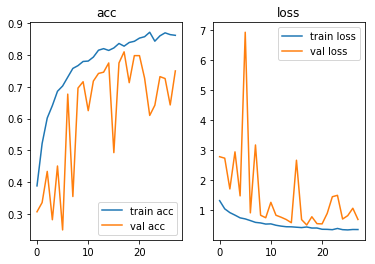

In [15]:
plt.subplot(121)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('acc')
plt.legend(['train acc', 'val acc'])
plt.subplot(122)
plt.plot(hist.history['loss']) 
plt.plot(hist.history['val_loss'])
plt.title('loss')
plt.legend(['train loss', 'val loss'])
plt.show()

We can see that while the train loss and acc got better the validation loss and acc
did got better over time but with lot's of jumps.

The model stopped after it couldn't get better for 10 ephocs.

Now that the model is all ready trained for some time on the data we will add augmentations to training proccess.

In [16]:
train = data_generator(x_train, y_train, 32, do_aug=True)

hist = oct_model.fit_generator(generator=train, epochs=100, steps_per_epoch=100,
                               verbose=1, callbacks=[early_stopping],
                               validation_data=(x_val_imgs, y_val))

Epoch 1/100
100/100 [==============================] - 89s 892ms/step - loss: 0.7452 - acc: 0.7066 - val_loss: 0.7181 - val_acc: 0.6930
Epoch 2/100
100/100 [==============================] - 90s 898ms/step - loss: 0.6821 - acc: 0.7253 - val_loss: 1.1130 - val_acc: 0.6360
Epoch 3/100
100/100 [==============================] - 88s 884ms/step - loss: 0.6495 - acc: 0.7466 - val_loss: 1.4040 - val_acc: 0.5460
Epoch 4/100
100/100 [==============================] - 88s 881ms/step - loss: 0.6166 - acc: 0.7634 - val_loss: 1.5384 - val_acc: 0.5690
Epoch 5/100
100/100 [==============================] - 88s 882ms/step - loss: 0.6004 - acc: 0.7597 - val_loss: 0.6585 - val_acc: 0.7500
Epoch 6/100
100/100 [==============================] - 88s 882ms/step - loss: 0.5647 - acc: 0.7744 - val_loss: 1.0813 - val_acc: 0.6990
Epoch 7/100
100/100 [==============================] - 88s 880ms/step - loss: 0.5905 - acc: 0.7588 - val_loss: 0.8001 - val_acc: 0.7430
Epoch 8/100
100/100 [===========================

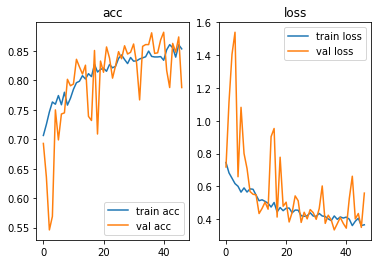

In [17]:
plt.subplot(121)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('acc')
plt.legend(['train acc', 'val acc'])
plt.subplot(122)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('loss')
plt.legend(['train loss', 'val loss'])
plt.show()

We can see now the model got better and the loss dropped eventually from 0.51 to 0.33.
another fact that we can see is that compared to the first run now the validation sometimes 
got even better result than the train and that is due to the augmentations making the training harder.

In [19]:
oct_model.save('oct_model.h5')

In [20]:
from keras.models import load_model
oct_model = load_model('oct_model.h5')

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.plot()

accuracy is: 0.971


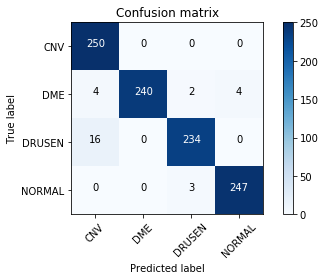

In [22]:
pred = oct_model.predict(load_images(x_test, dim3=True)/256)
cm = confusion_matrix(y_test.argmax(1), pred.argmax(1))

items = data2index.items()
classes = [item[0] for item in sorted(list(items), key=lambda x: x[1])]
print('accuracy is:', accuracy_score(y_test.argmax(1), pred.argmax(1)))
plot_confusion_matrix(cm, classes)

We see that we got exellent result in the test with 97.1% accuracy, even higher than in the training or validation.
I'm not sure why exacly this happend, could be beacuse the images in the test are 
more "clean" than the one's in the train data.

In [23]:
def show_features_at(layer_name, image, lines=4, images_per_line=8):
    tmp_model = Model(oct_model.input, oct_model.get_layer(layer_name).output)
    features = tmp_model.predict(np.array([image]))
    plt.figure(figsize=[40, 20])
    for index in range(lines * images_per_line):
        plt.subplot(lines, images_per_line, index+1)
        plt.imshow(features[0,:,:,index], cmap='gray')
    plt.show()

conv_pw_1_relu


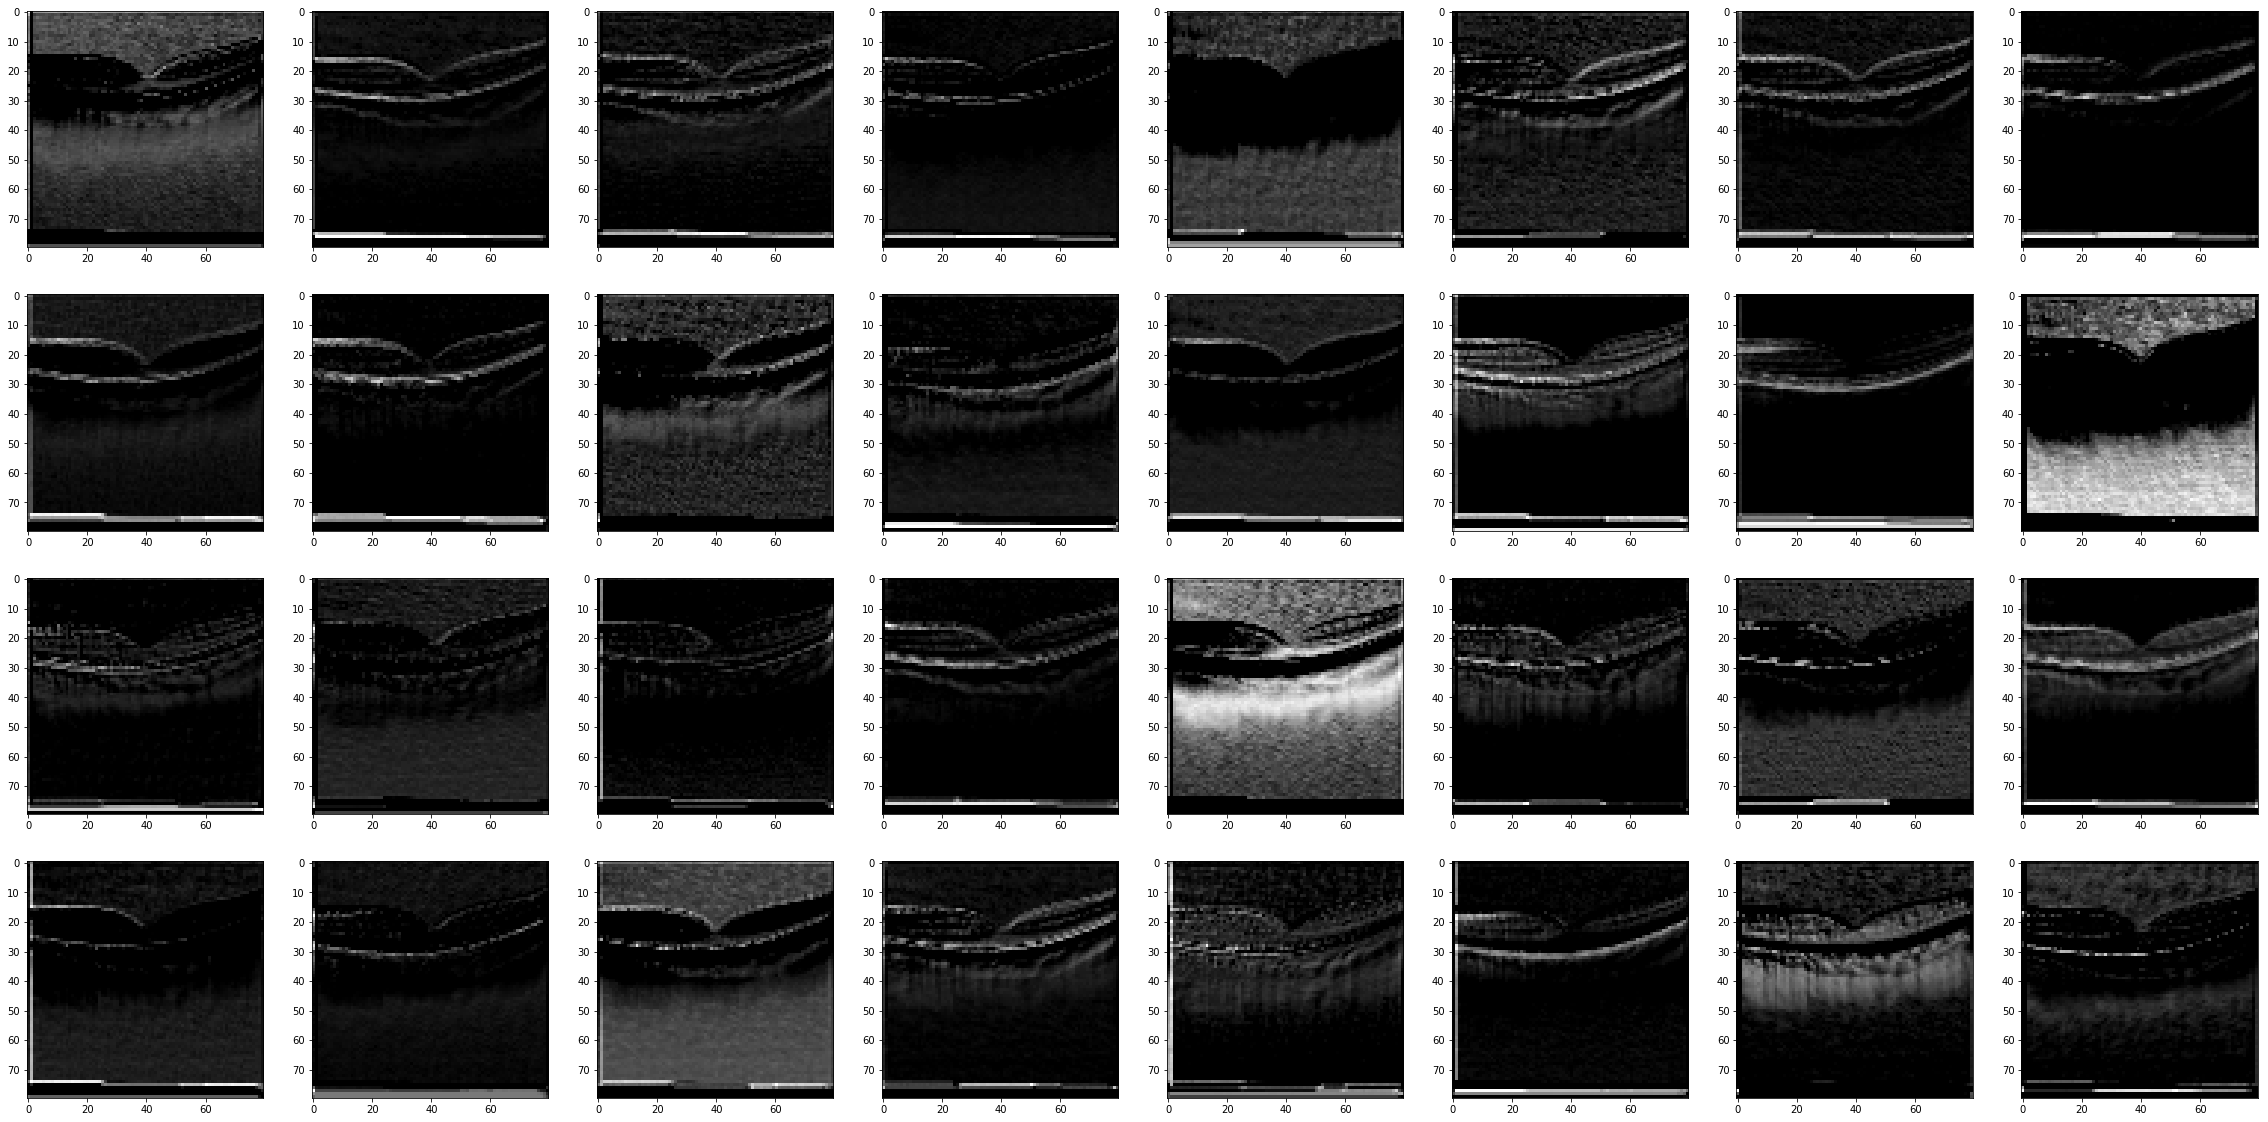

conv_pw_2_relu


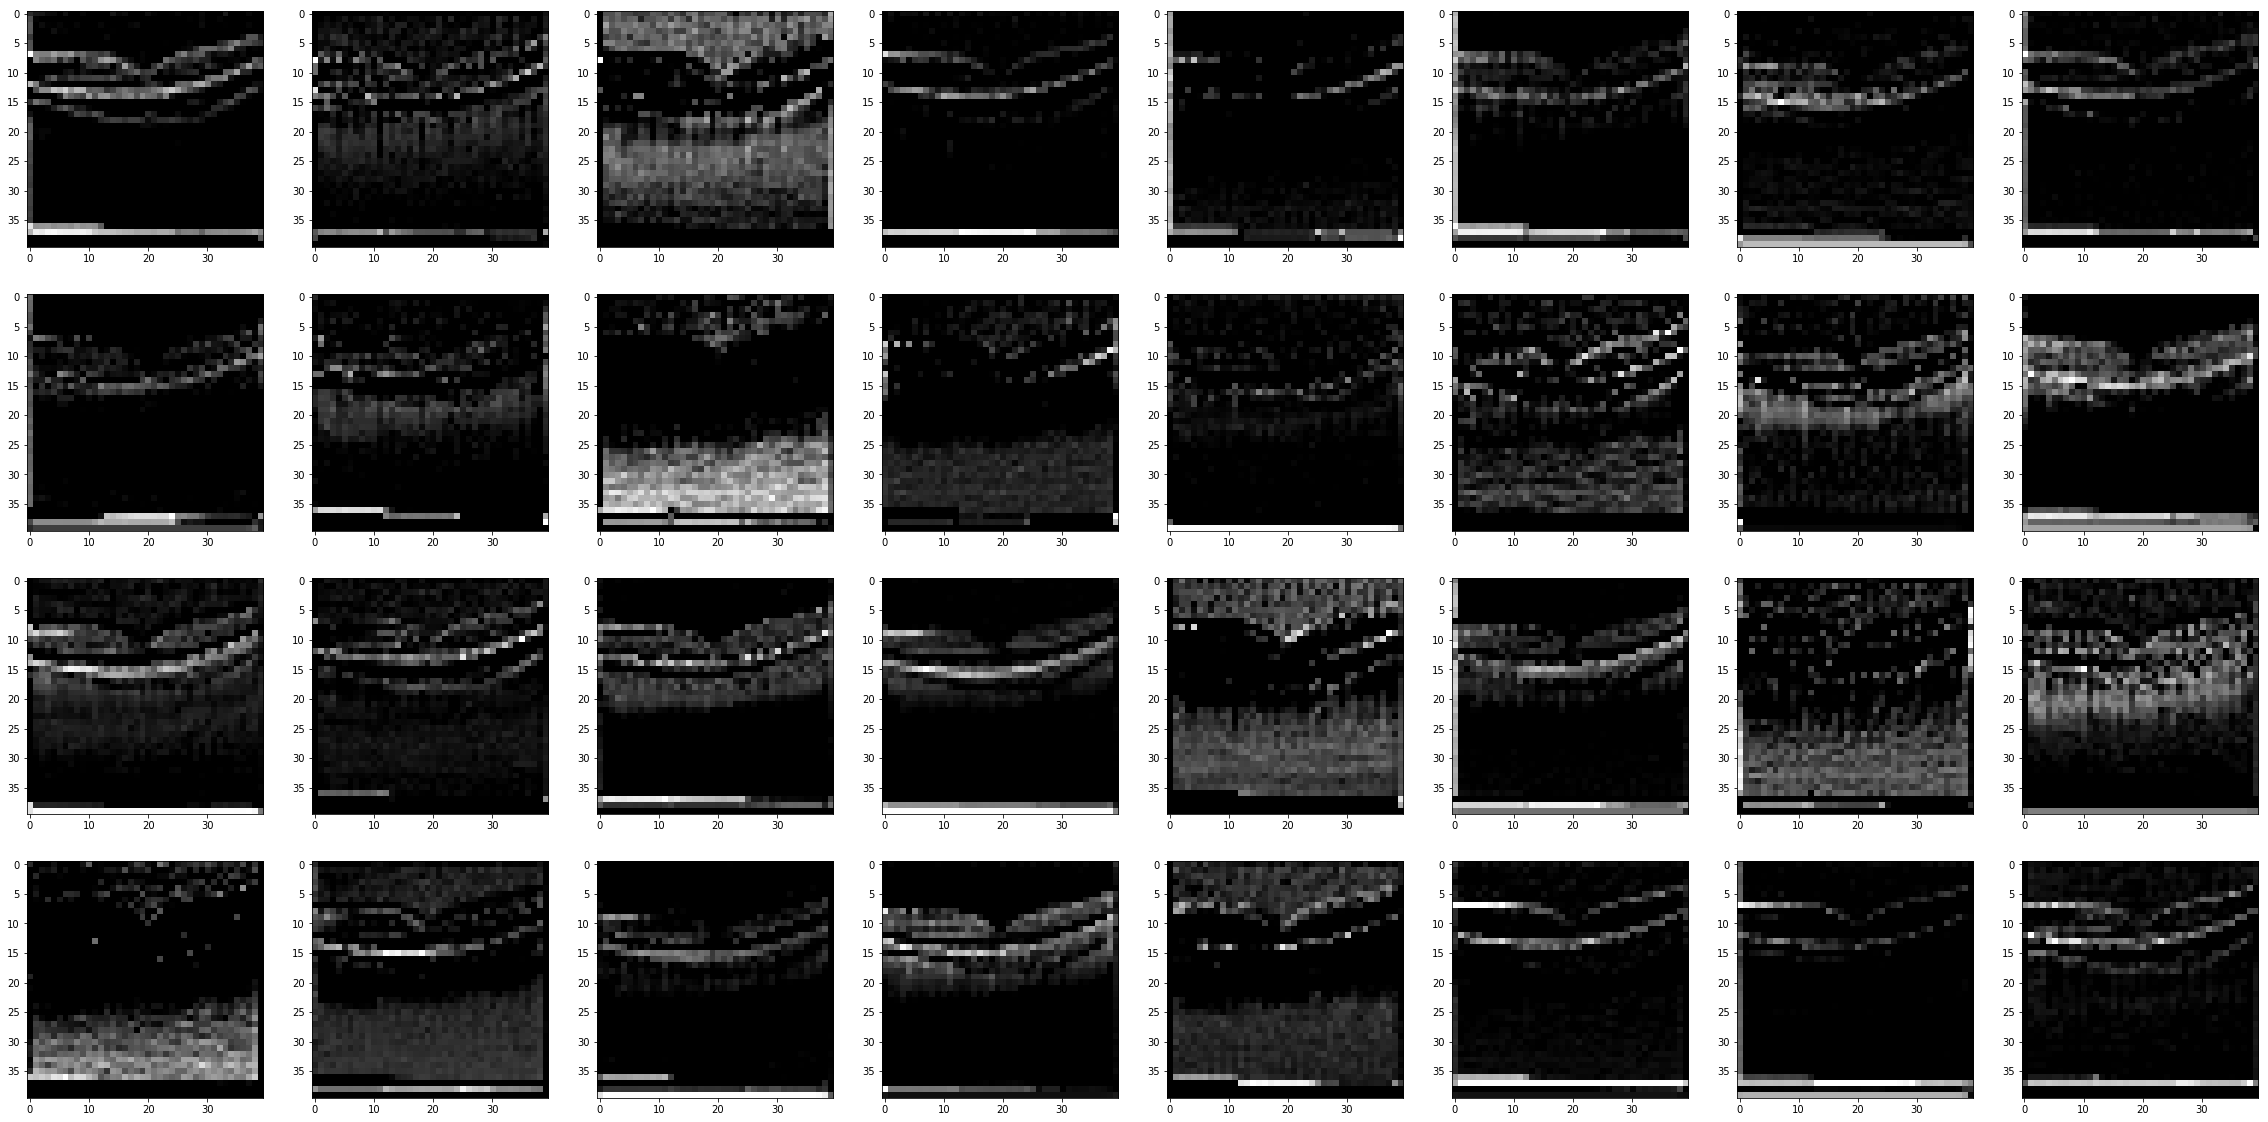

conv_pw_3_relu


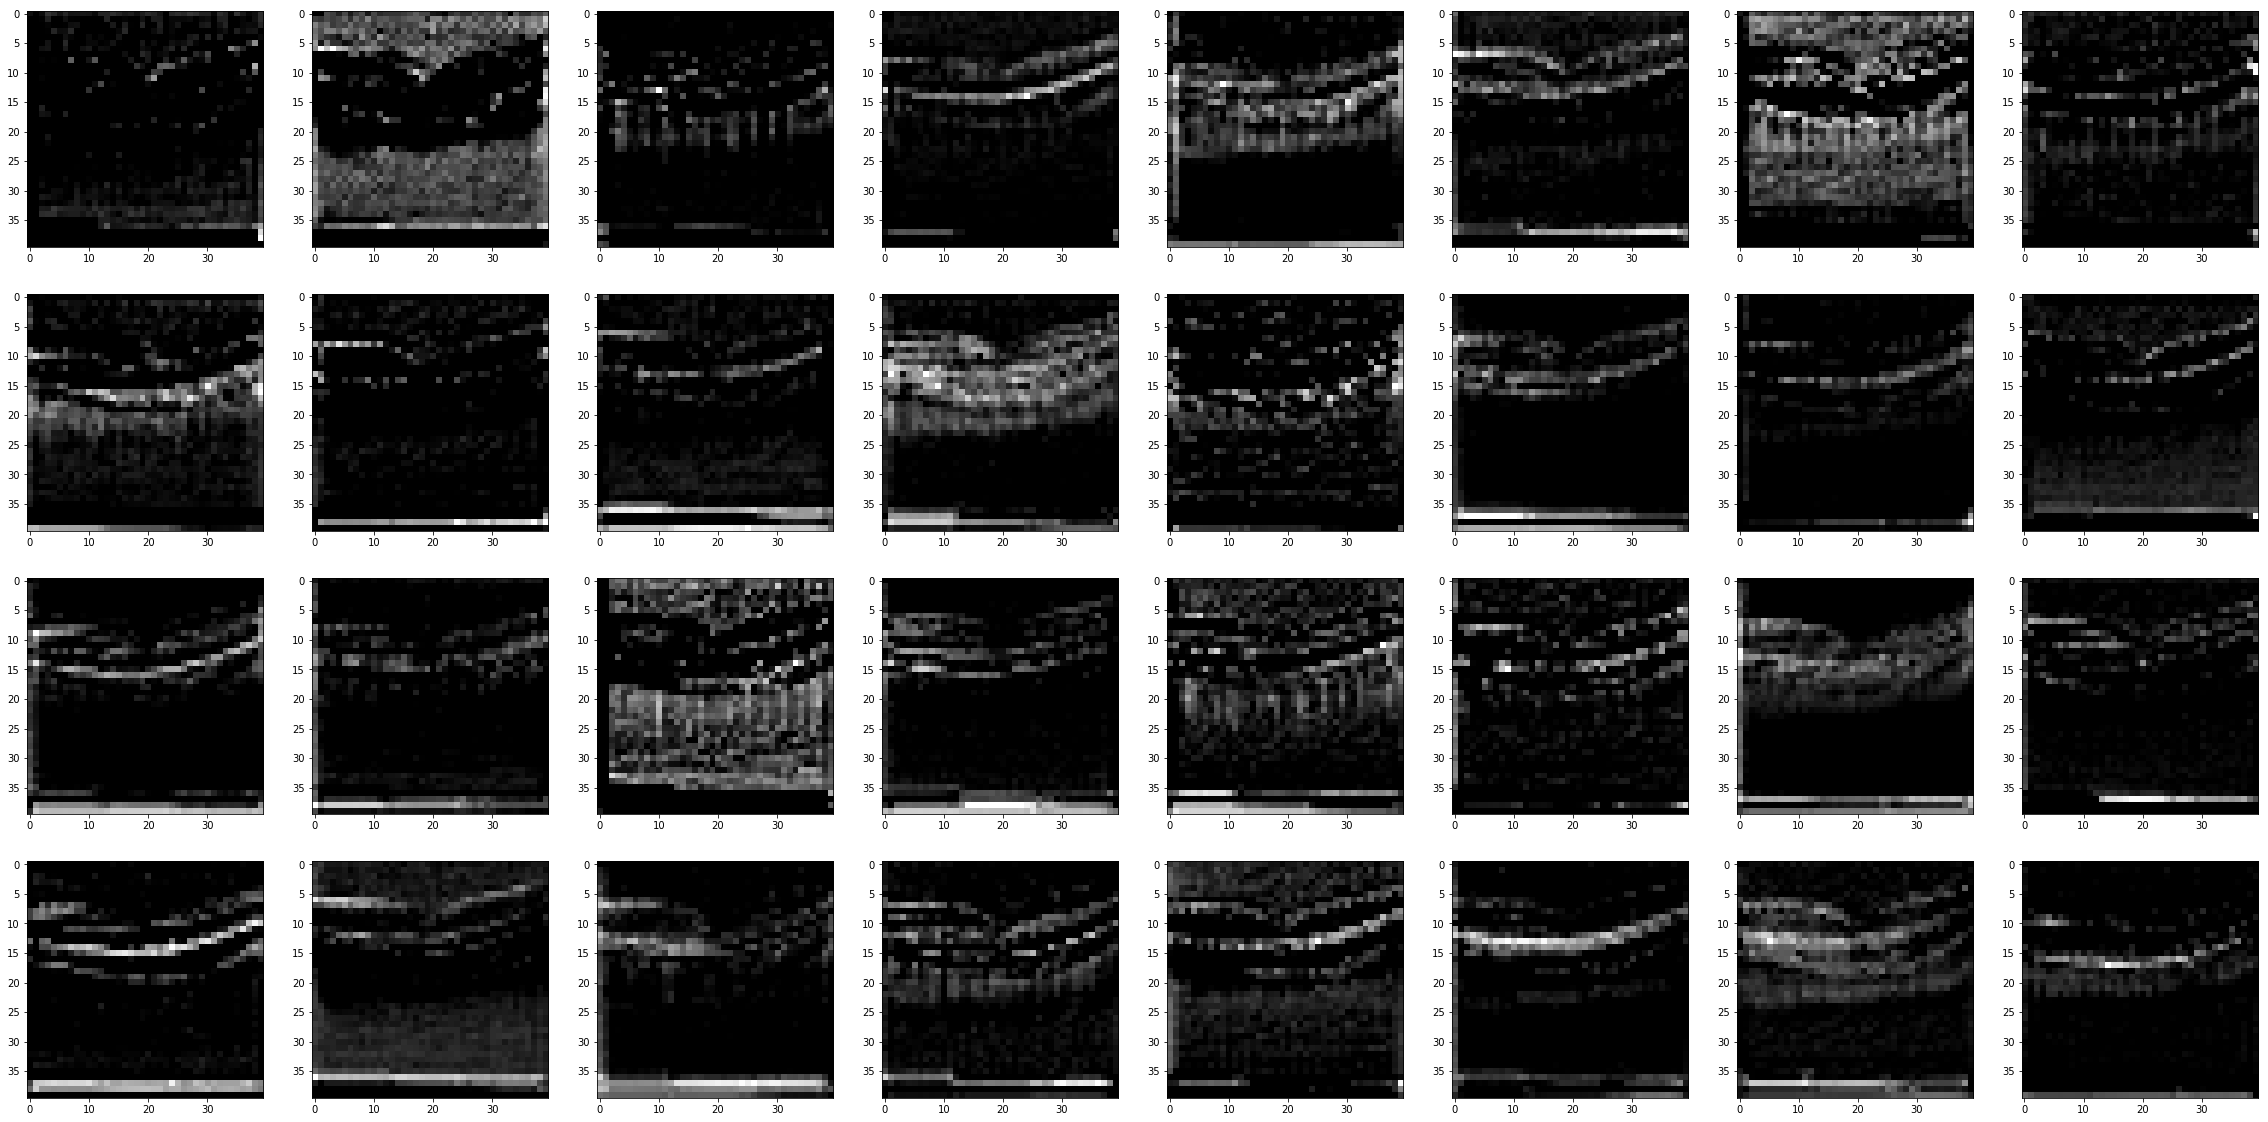

conv_pw_4_relu


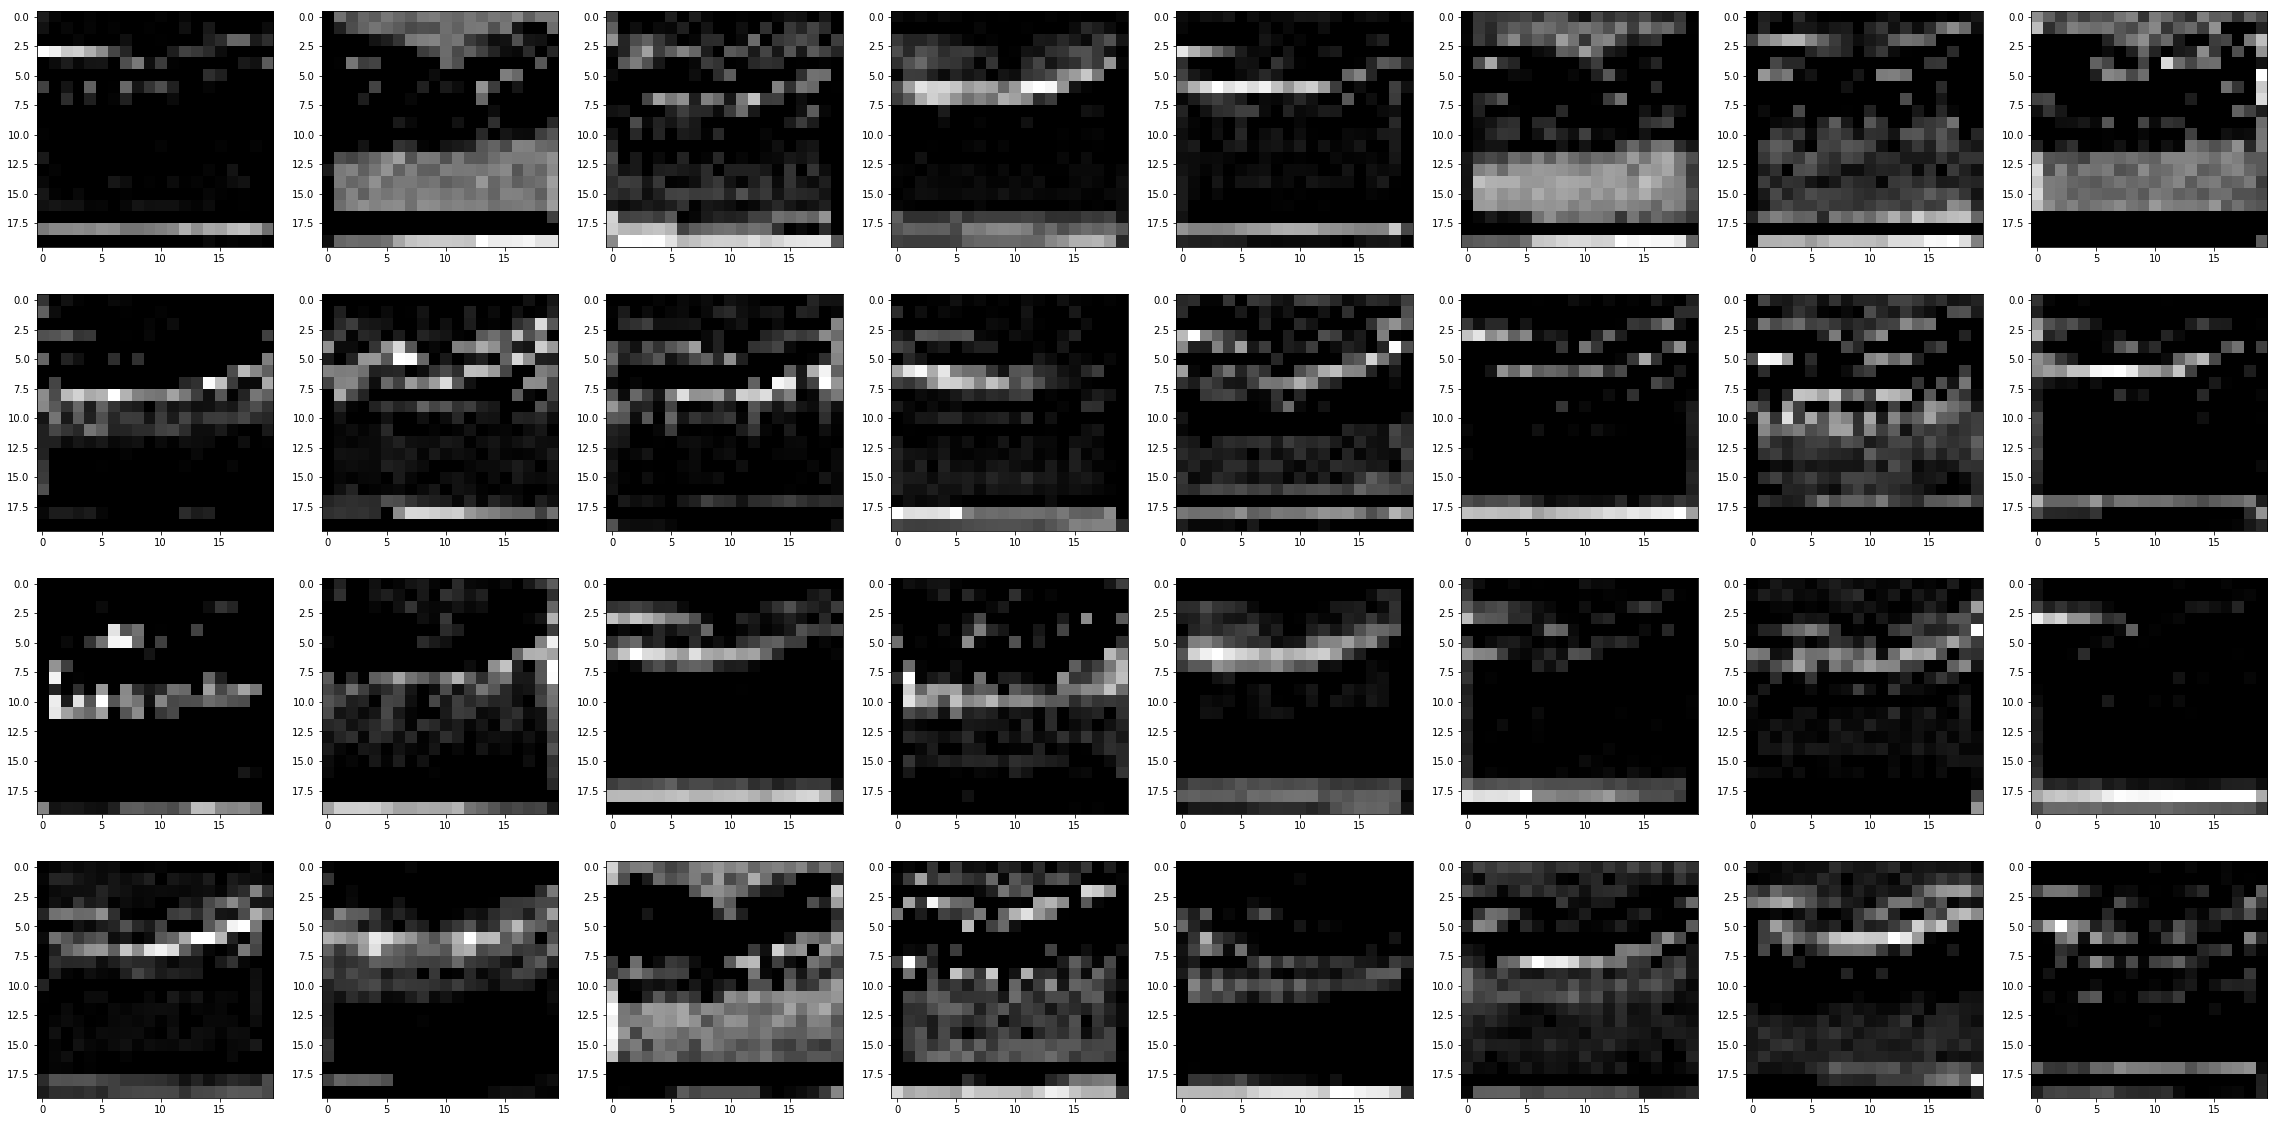

conv_pw_5_relu


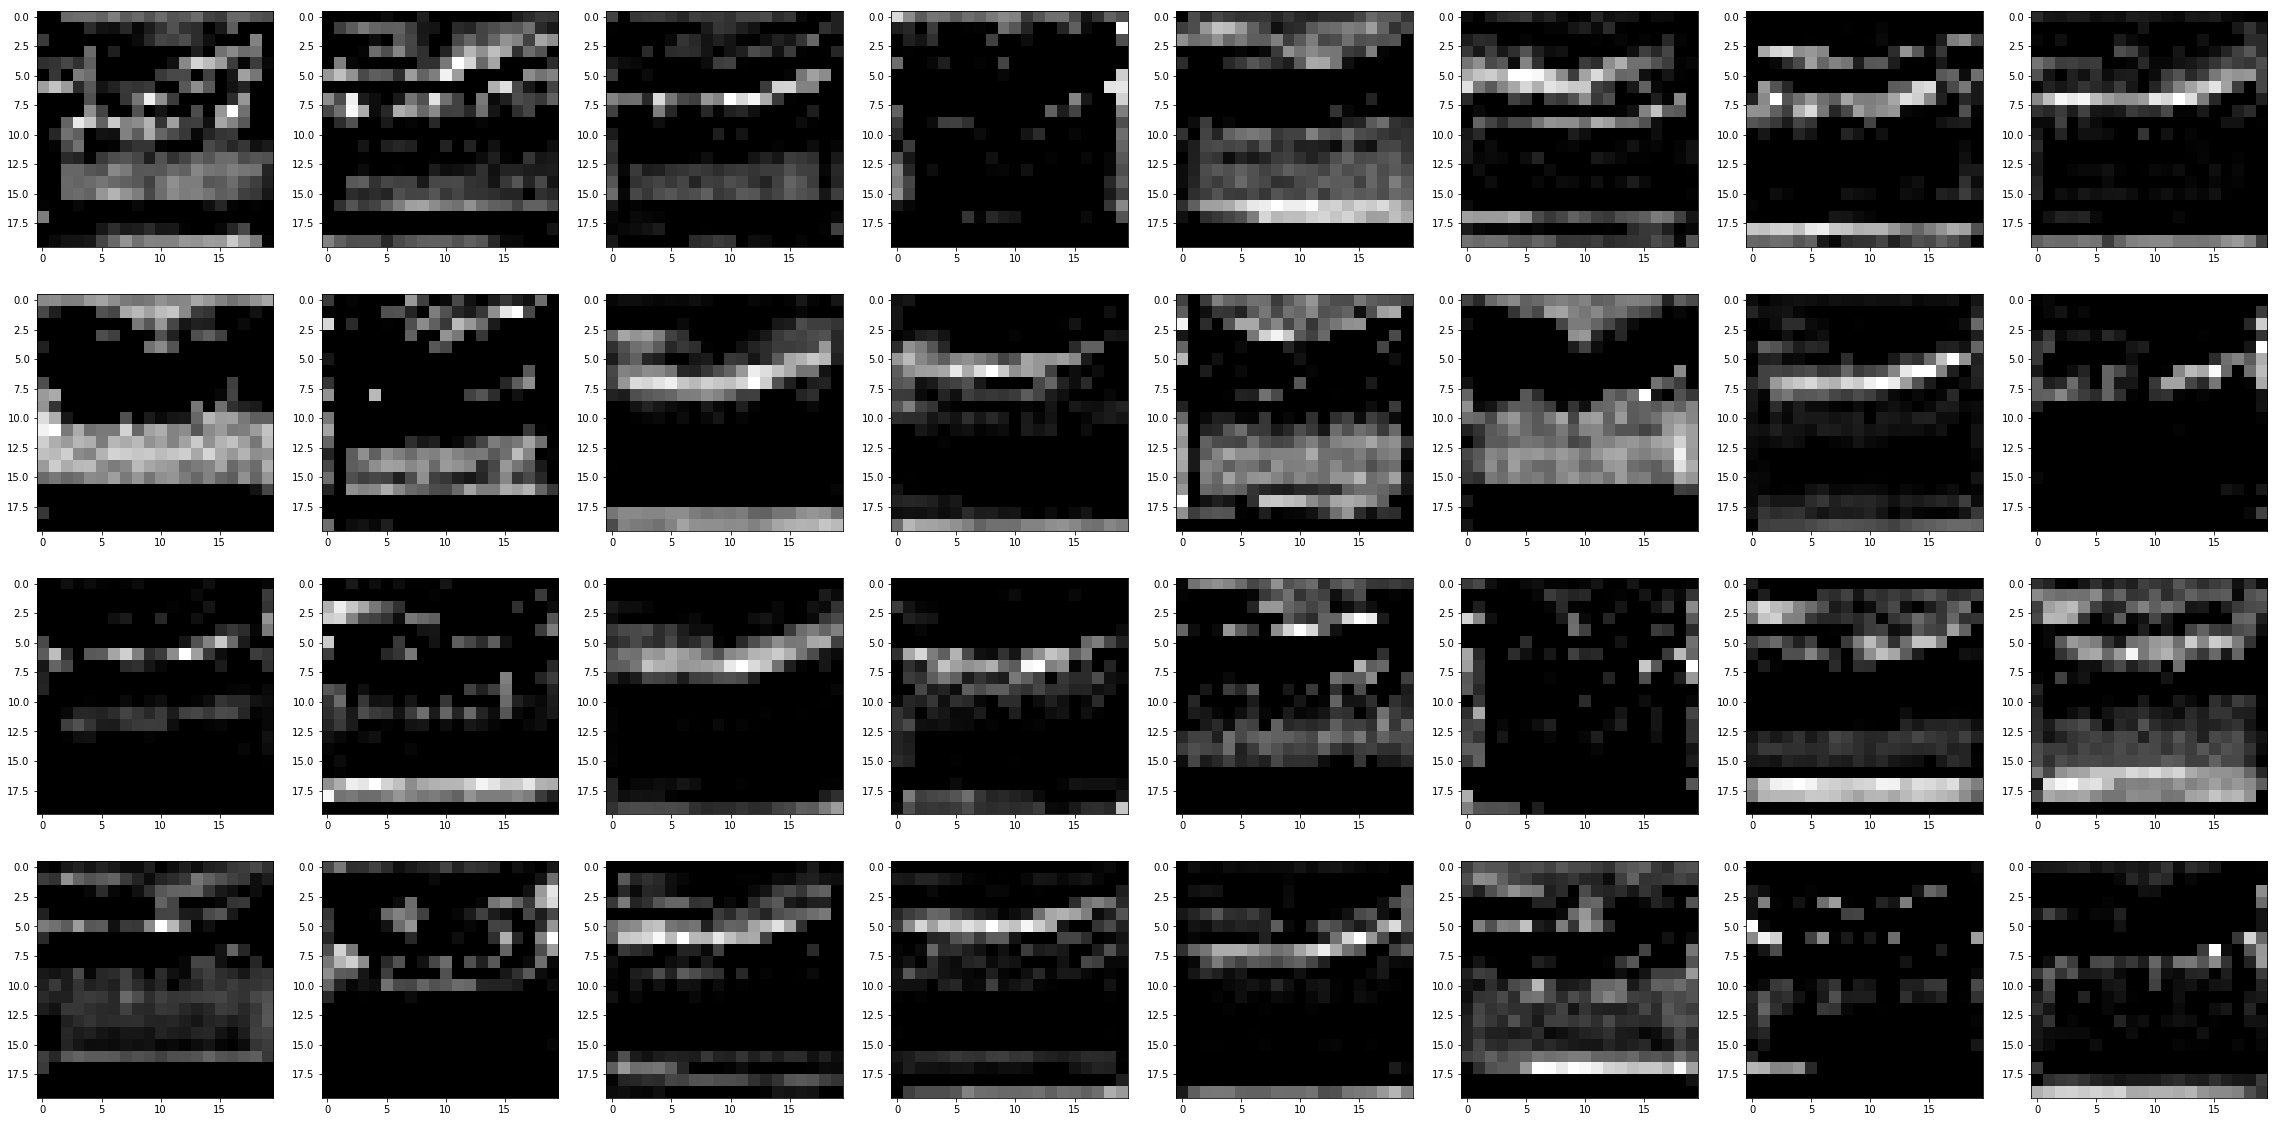

conv_pw_6_relu


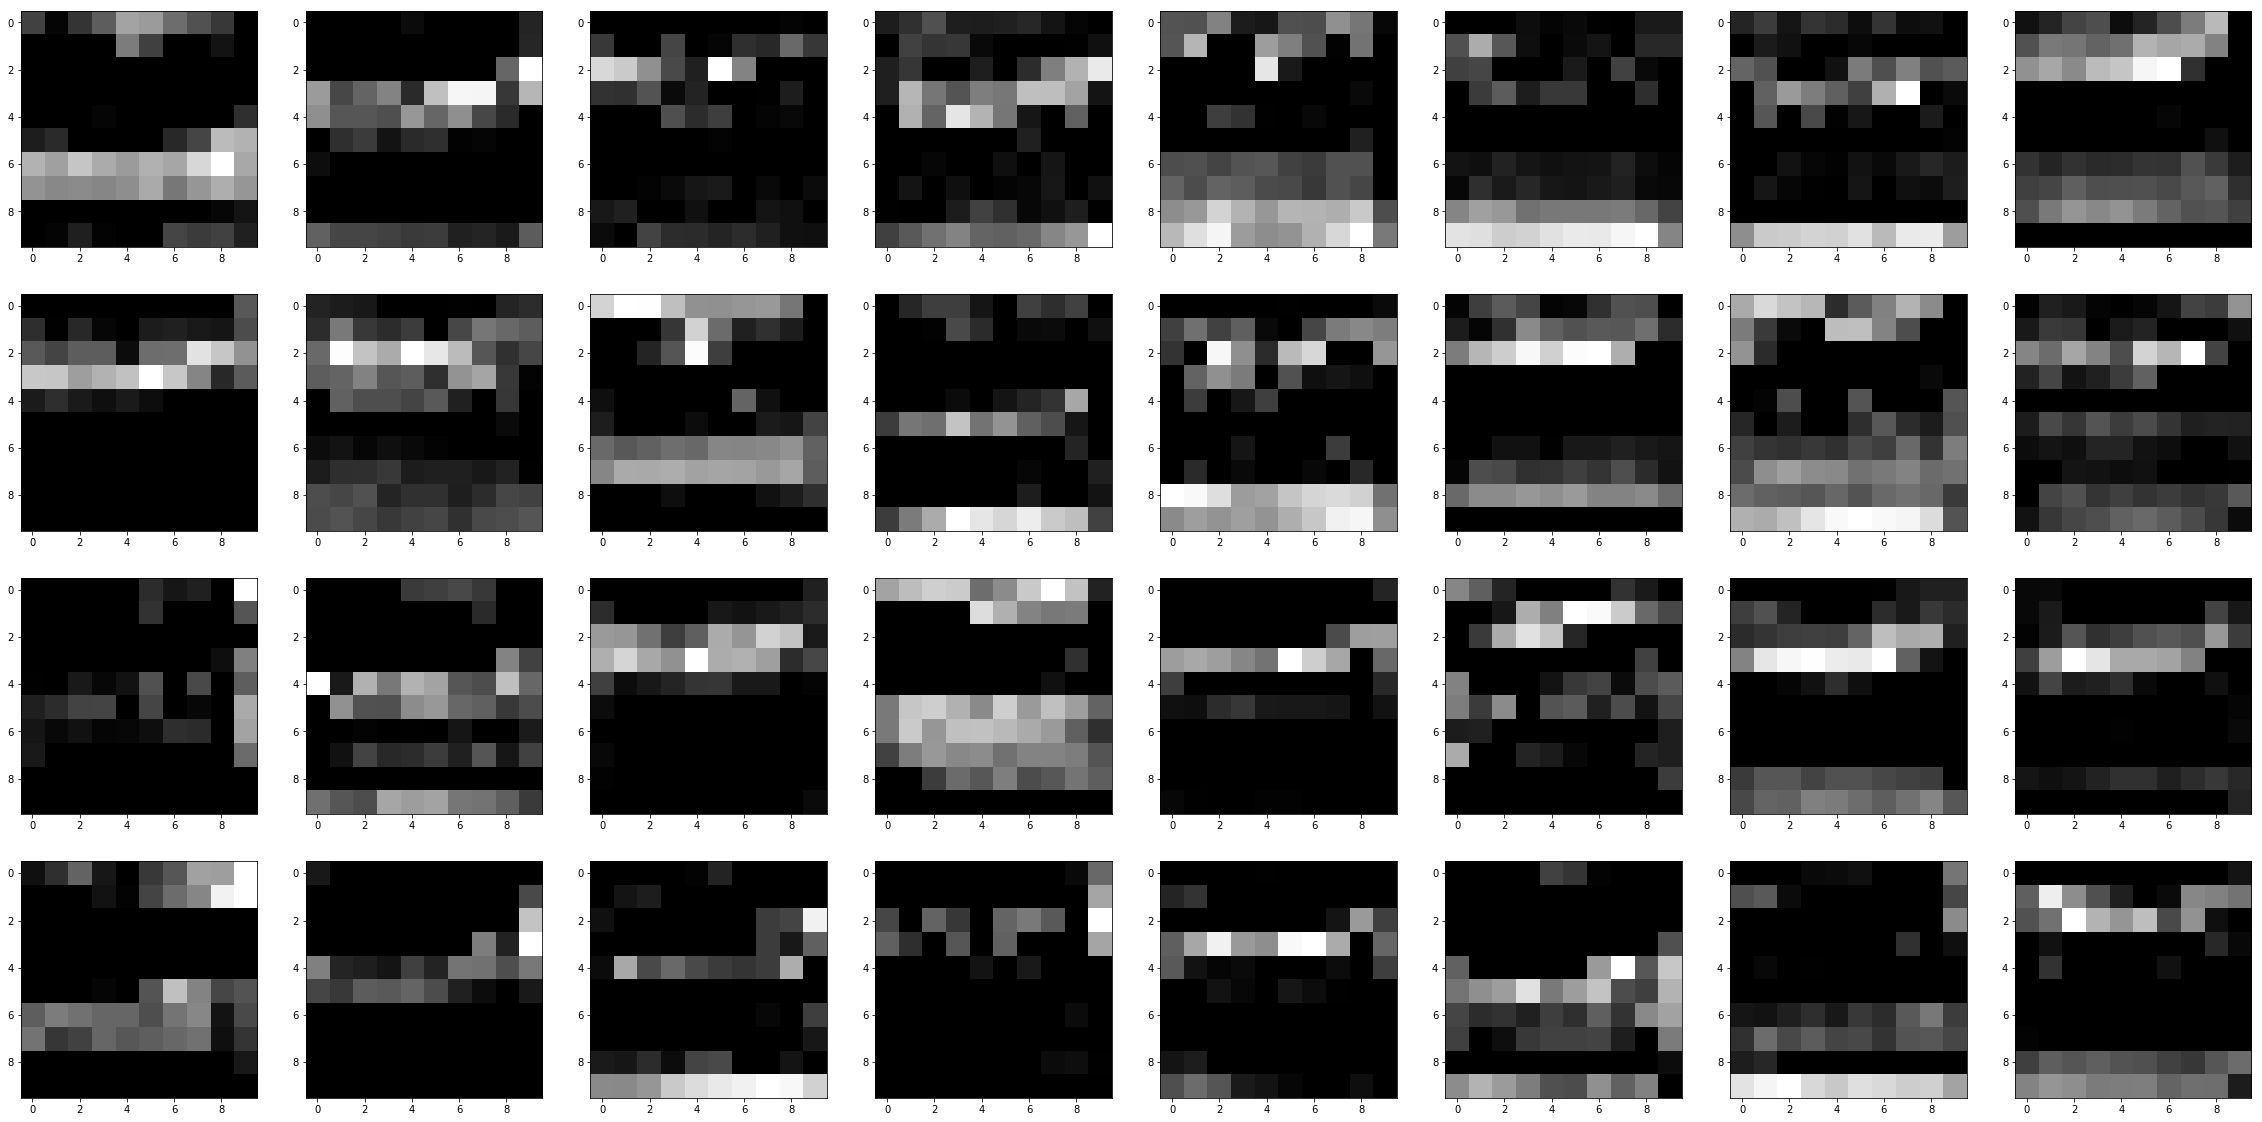

conv_pw_7_relu


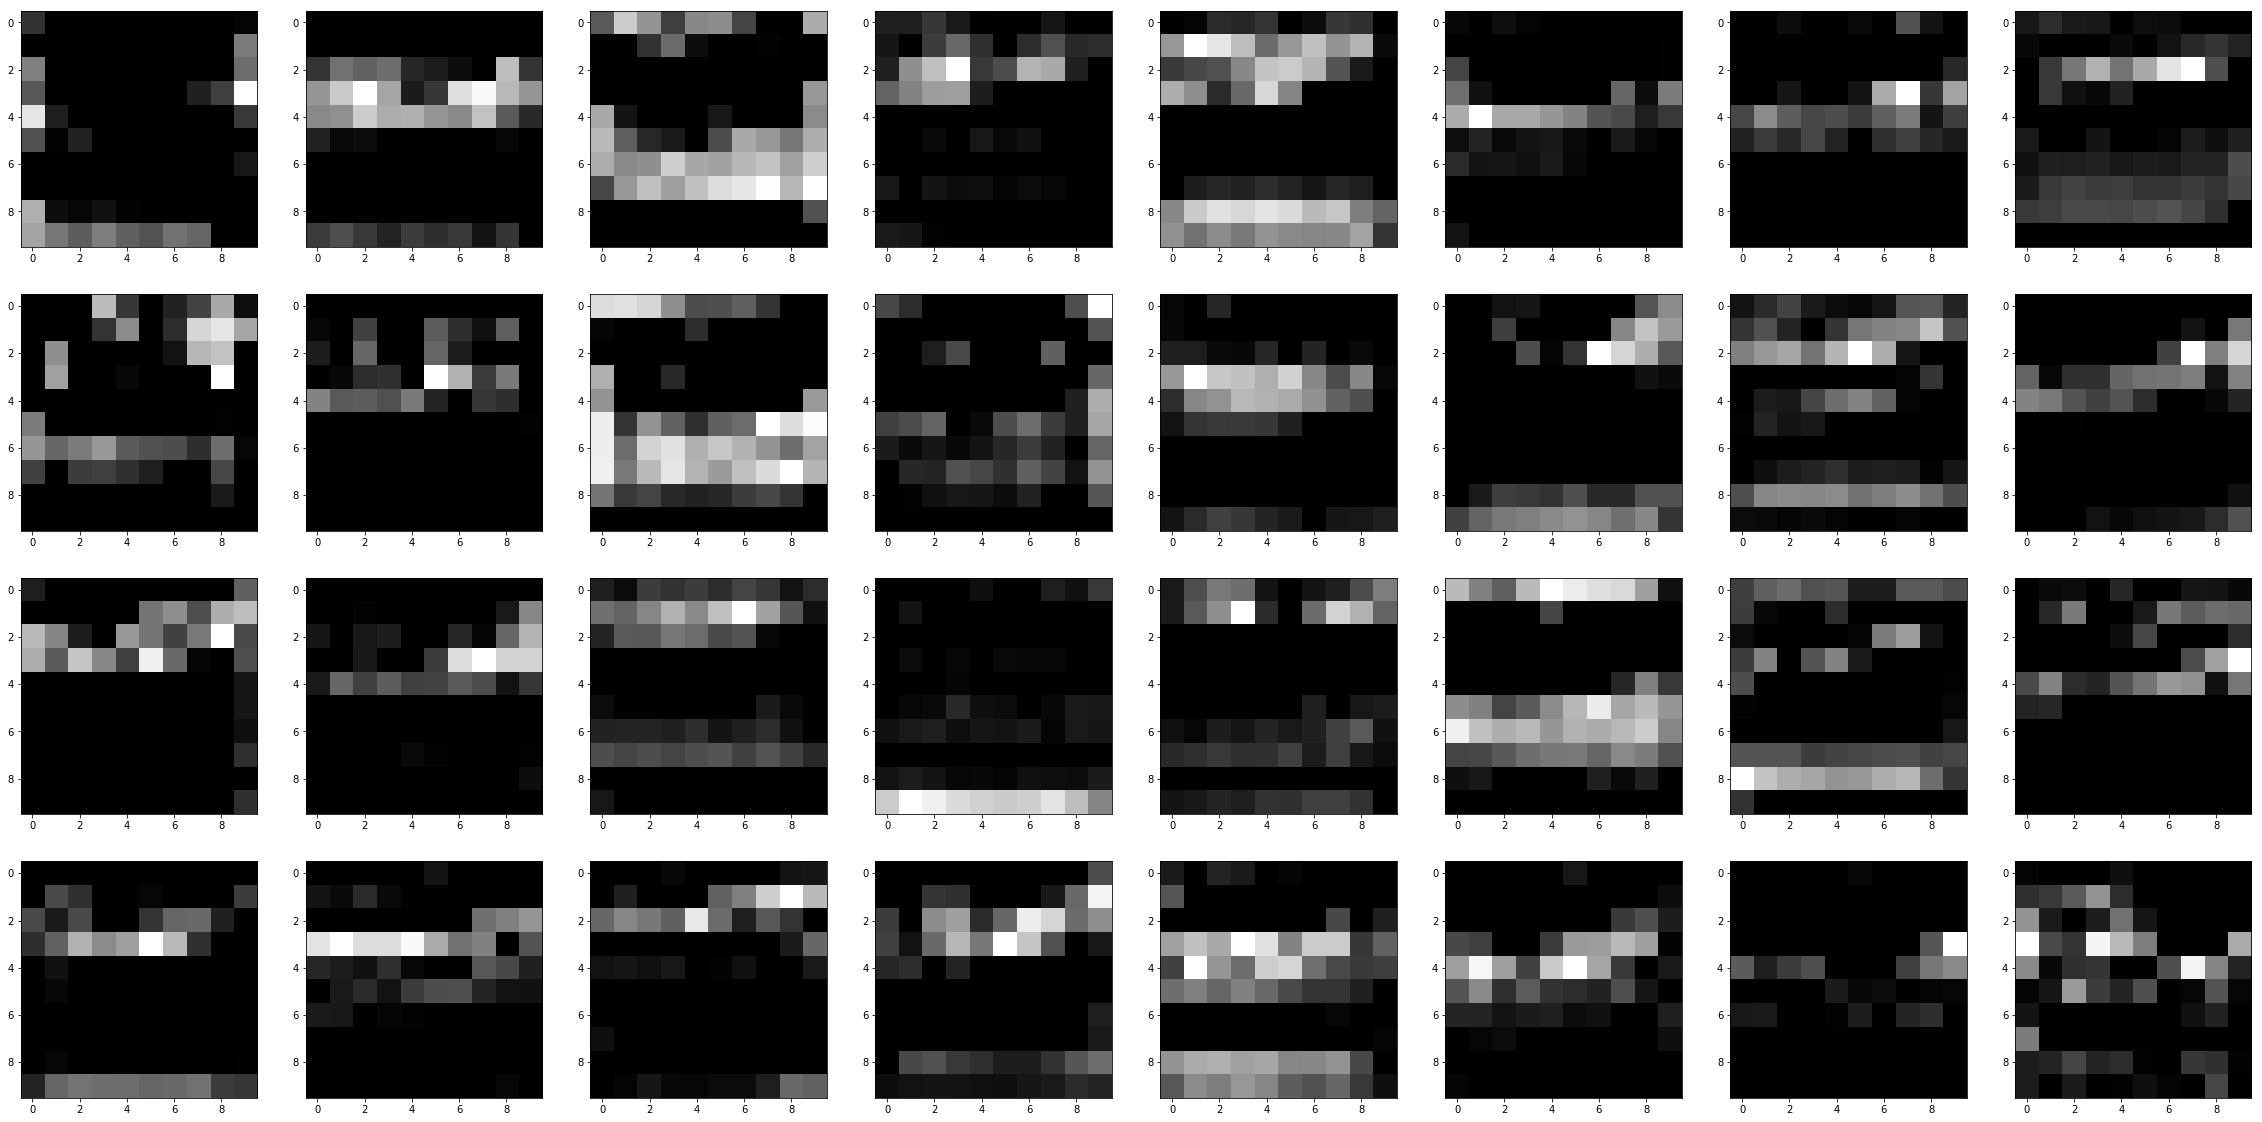

conv_pw_8_relu


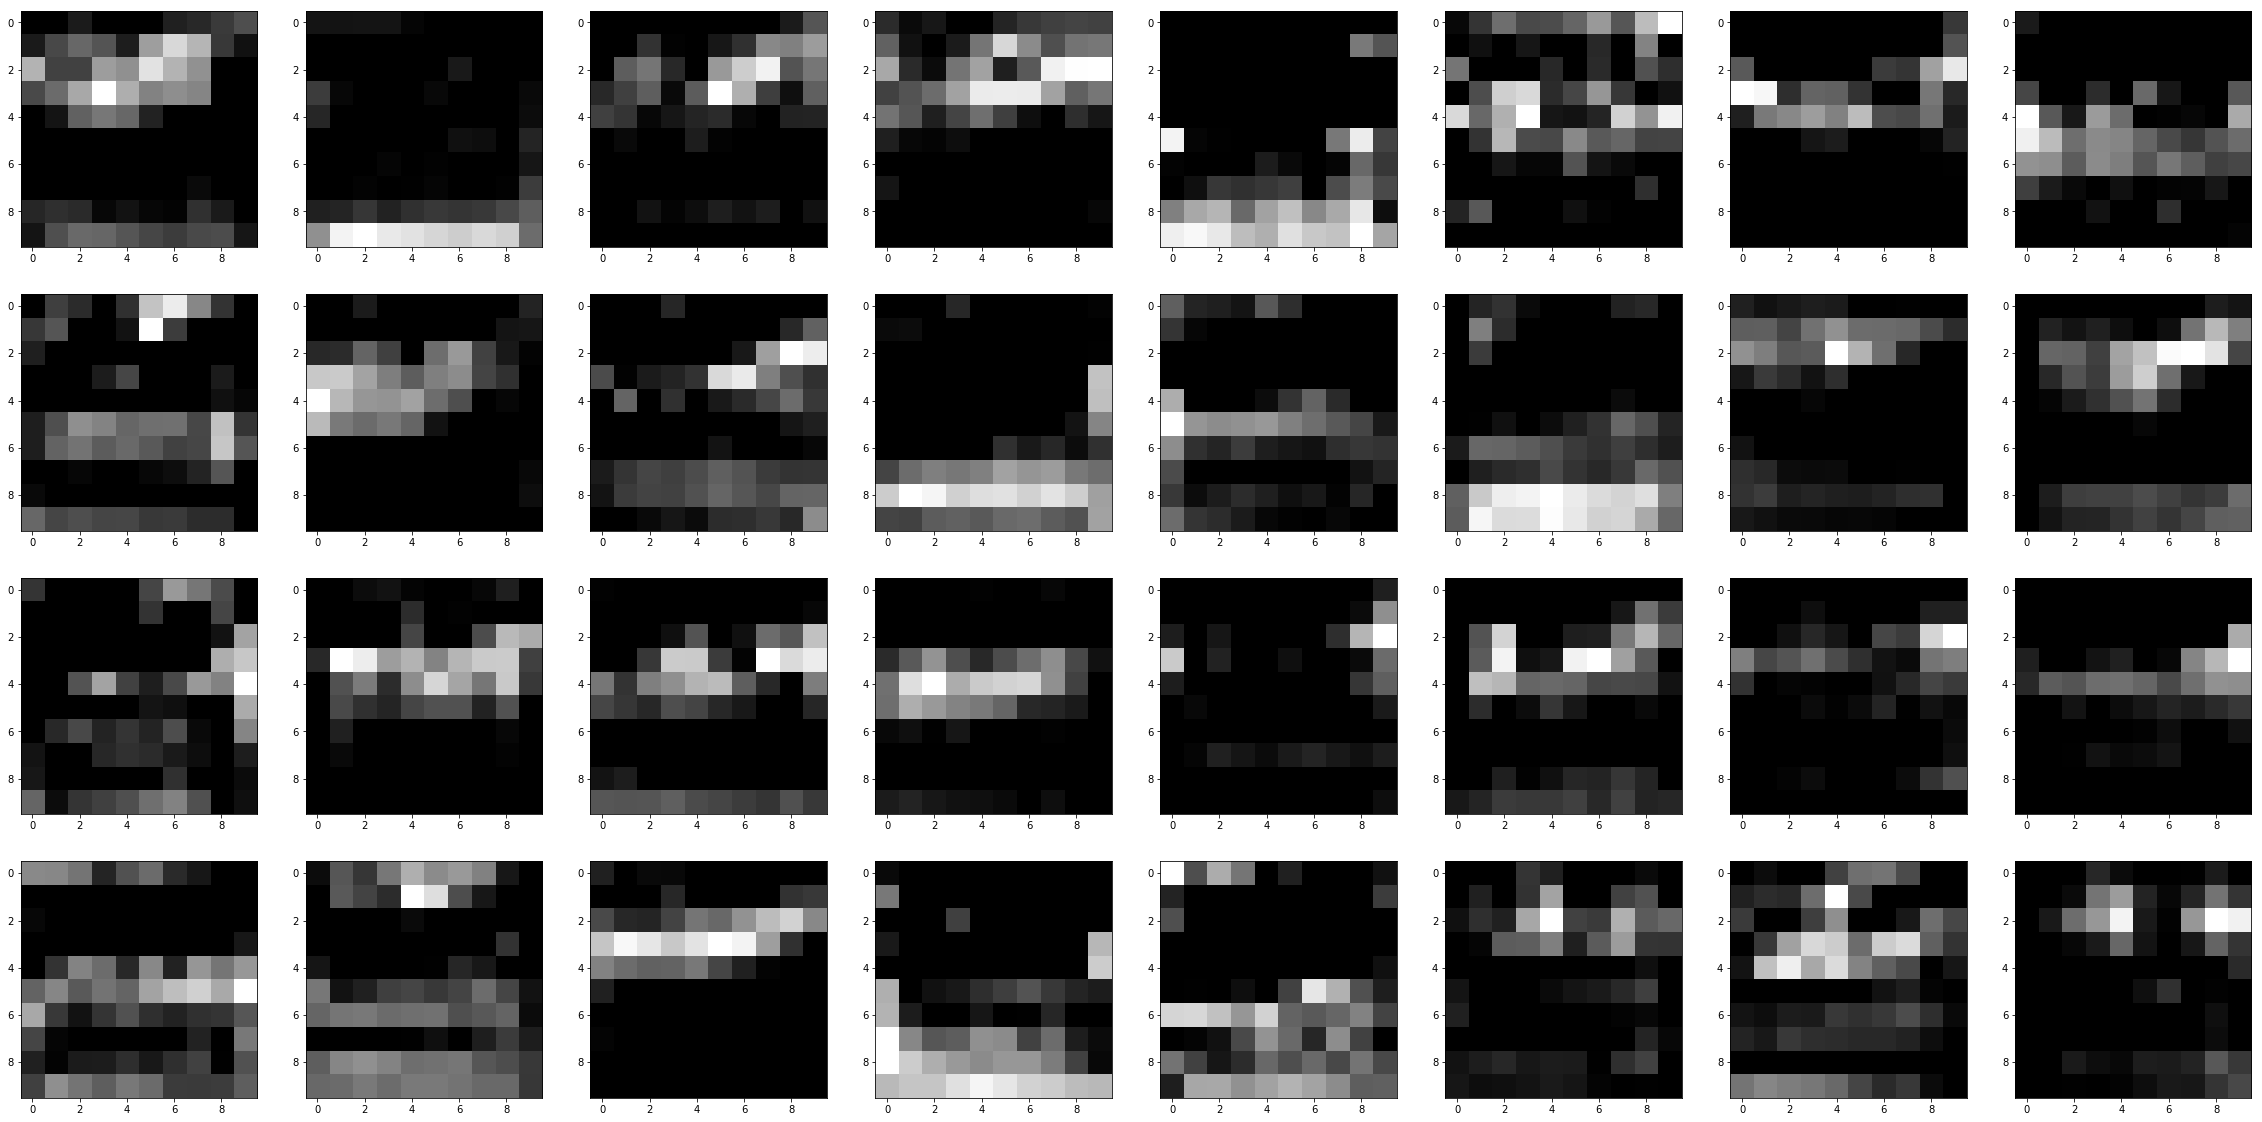

conv_pw_9_relu


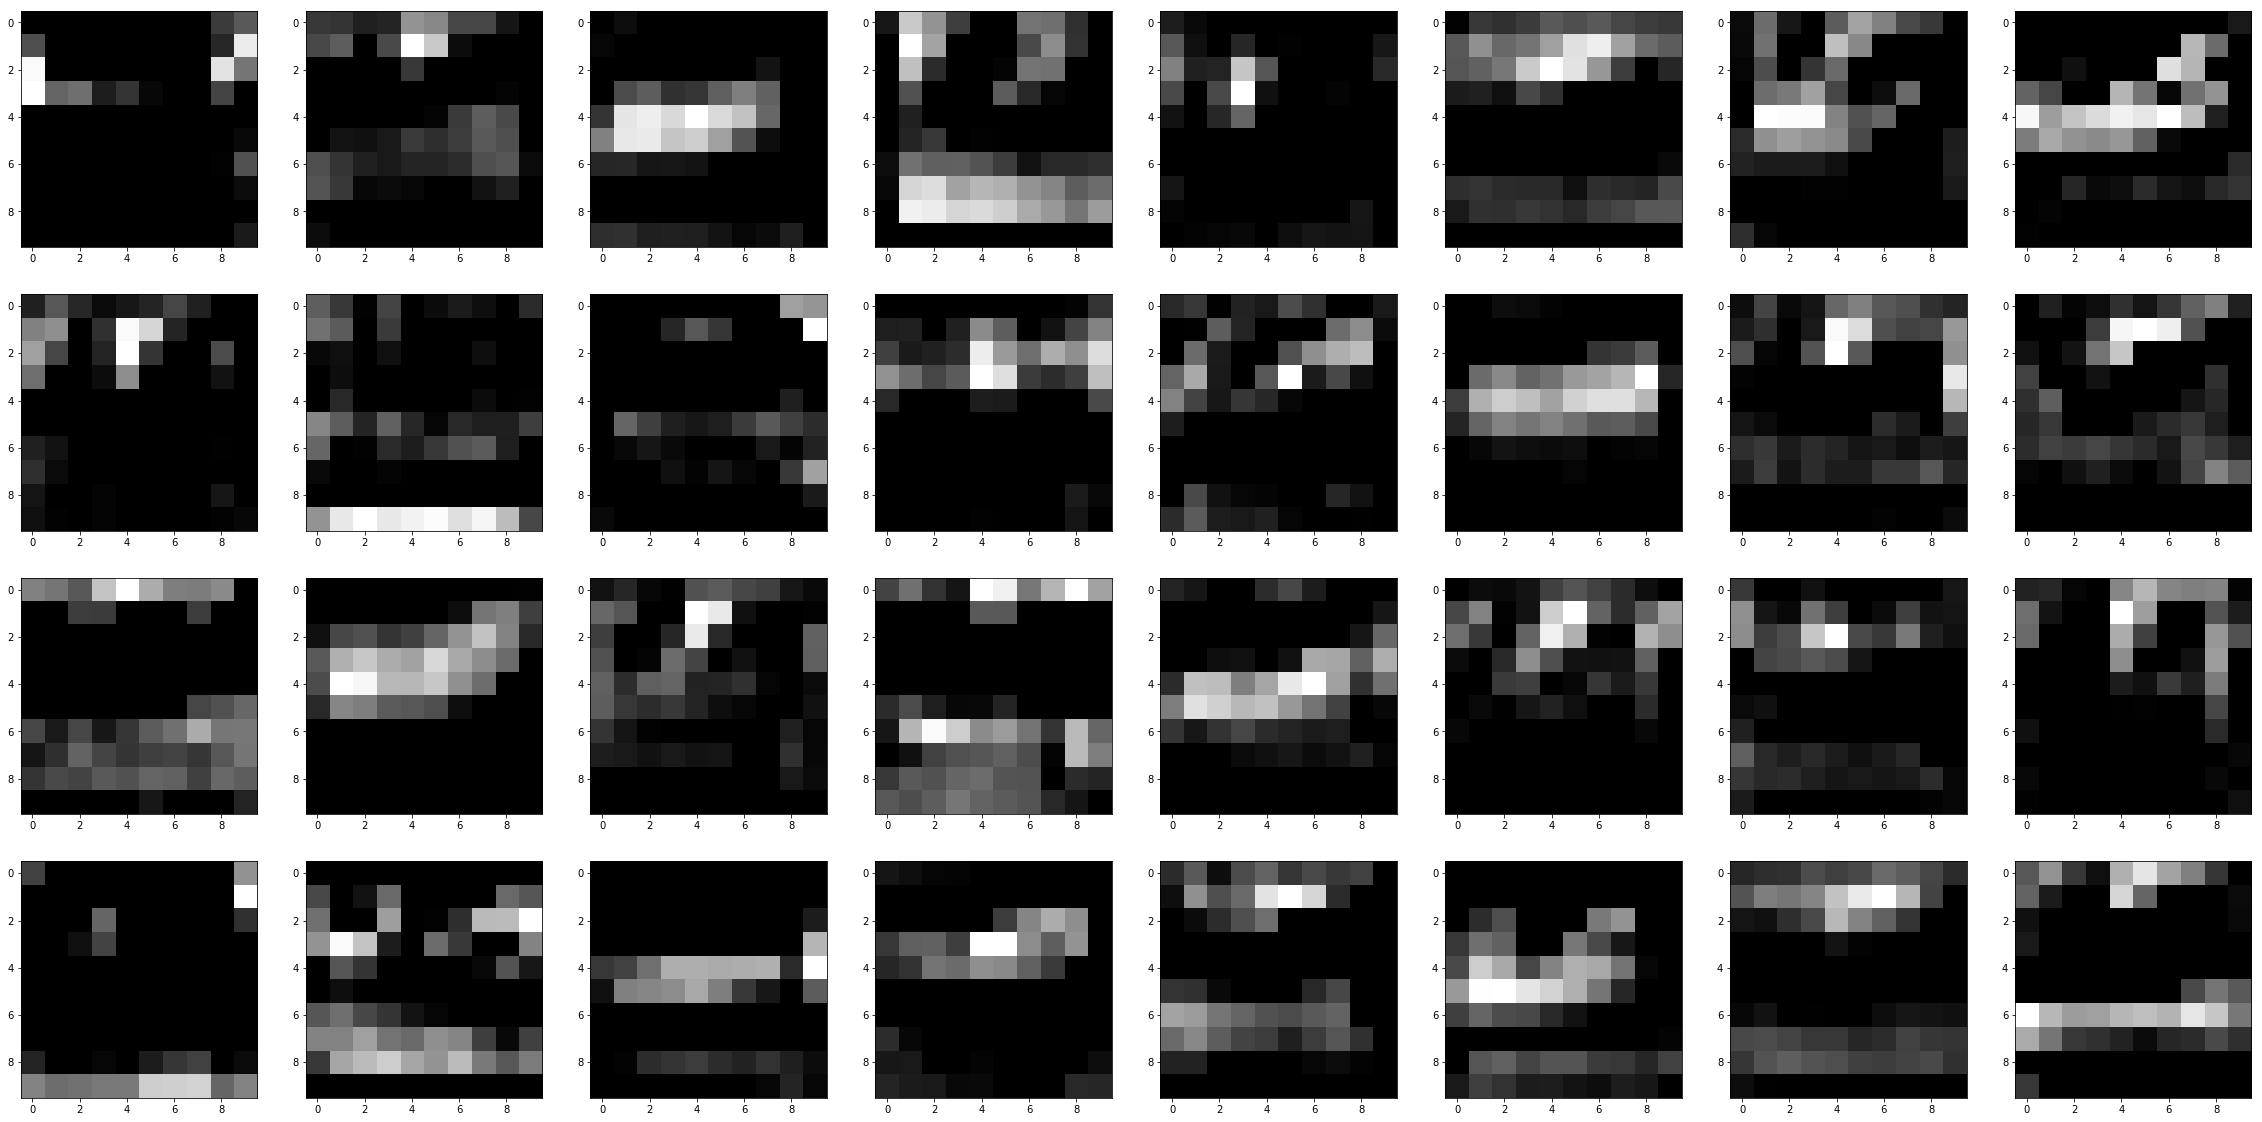

conv_pw_10_relu


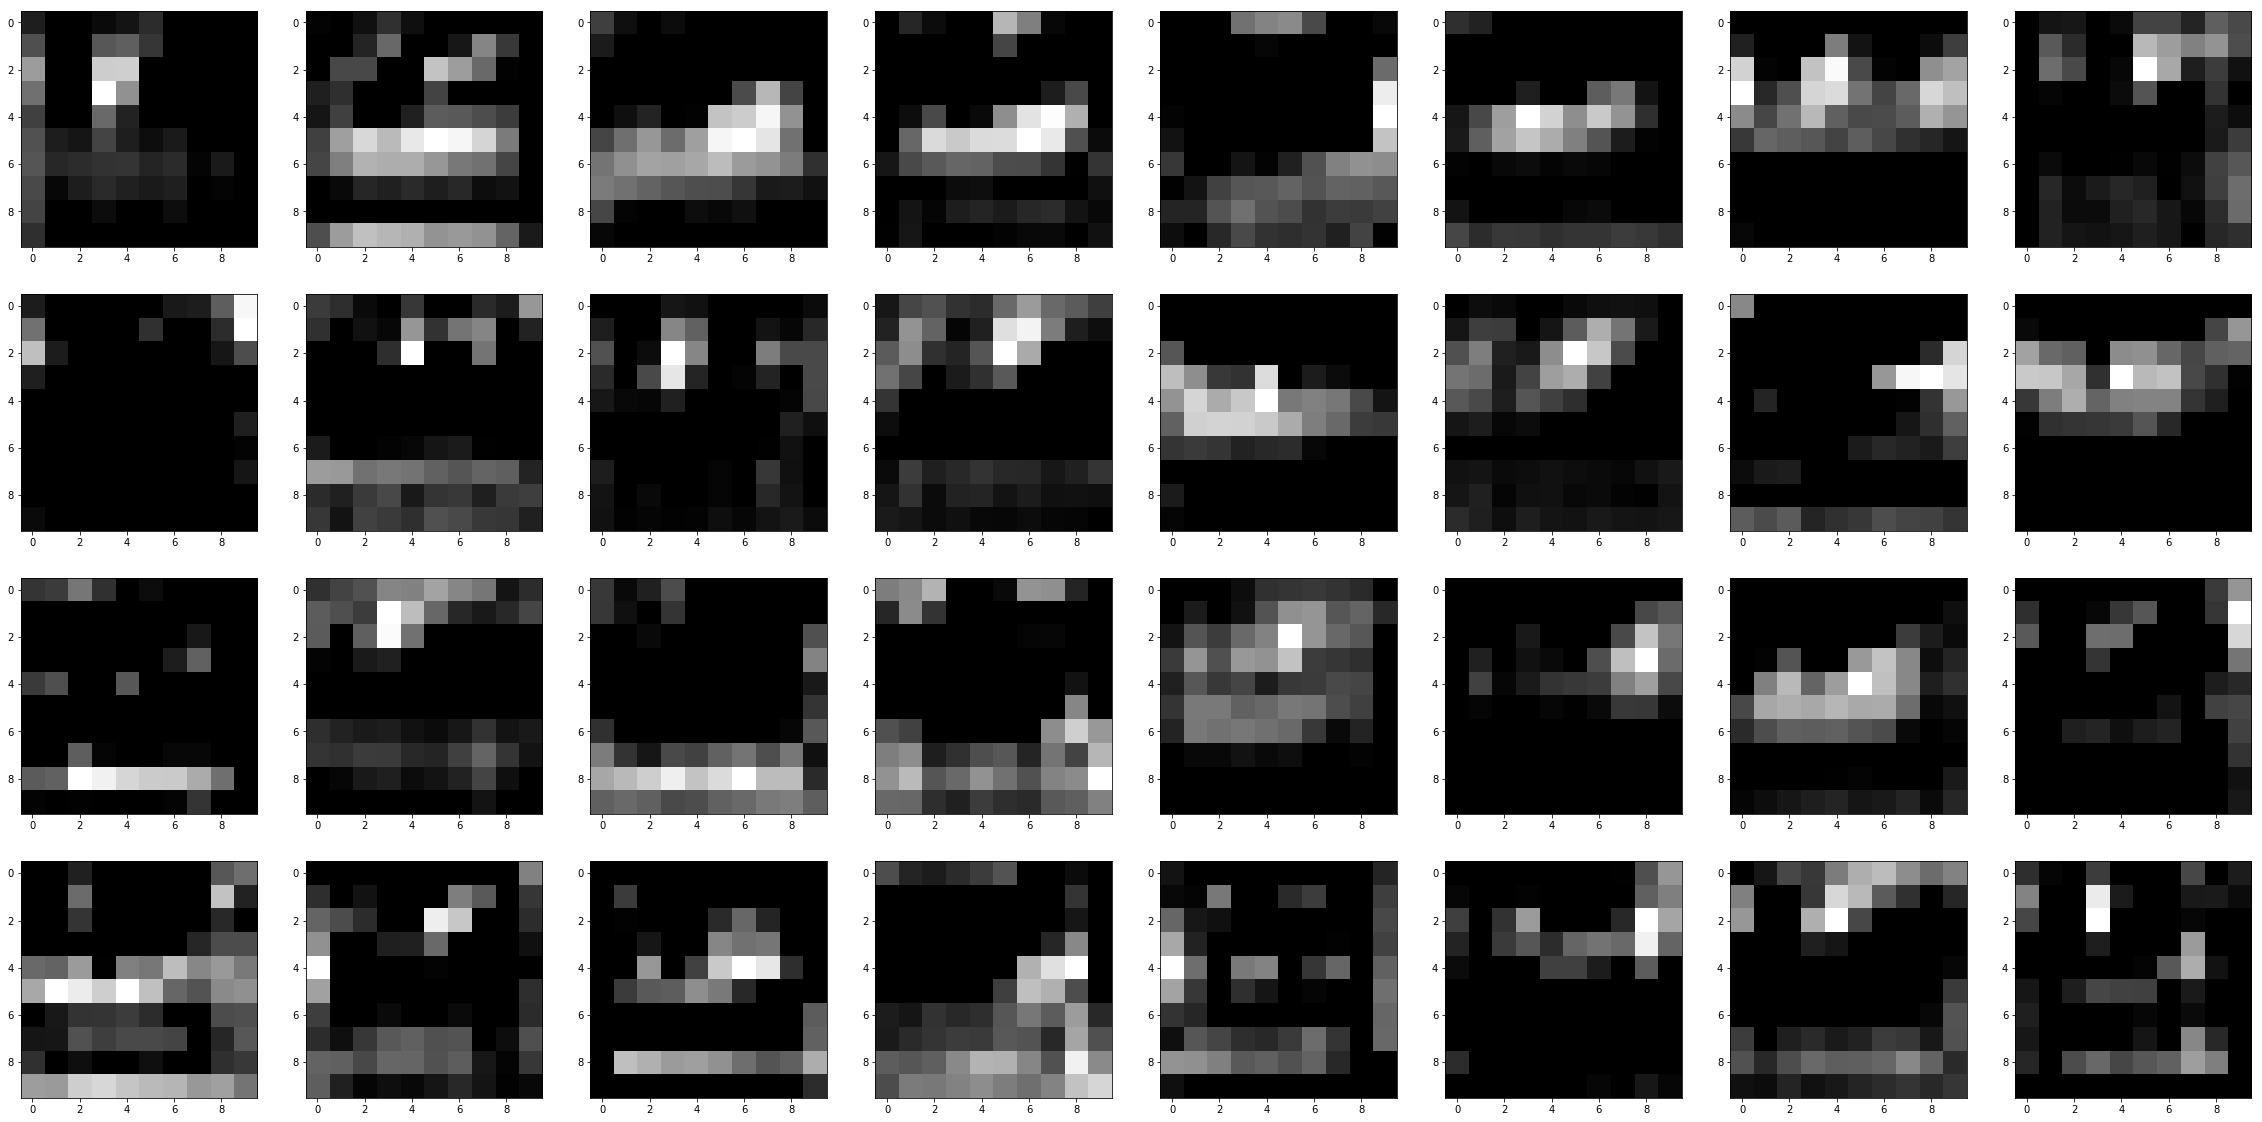

conv_pw_11_relu


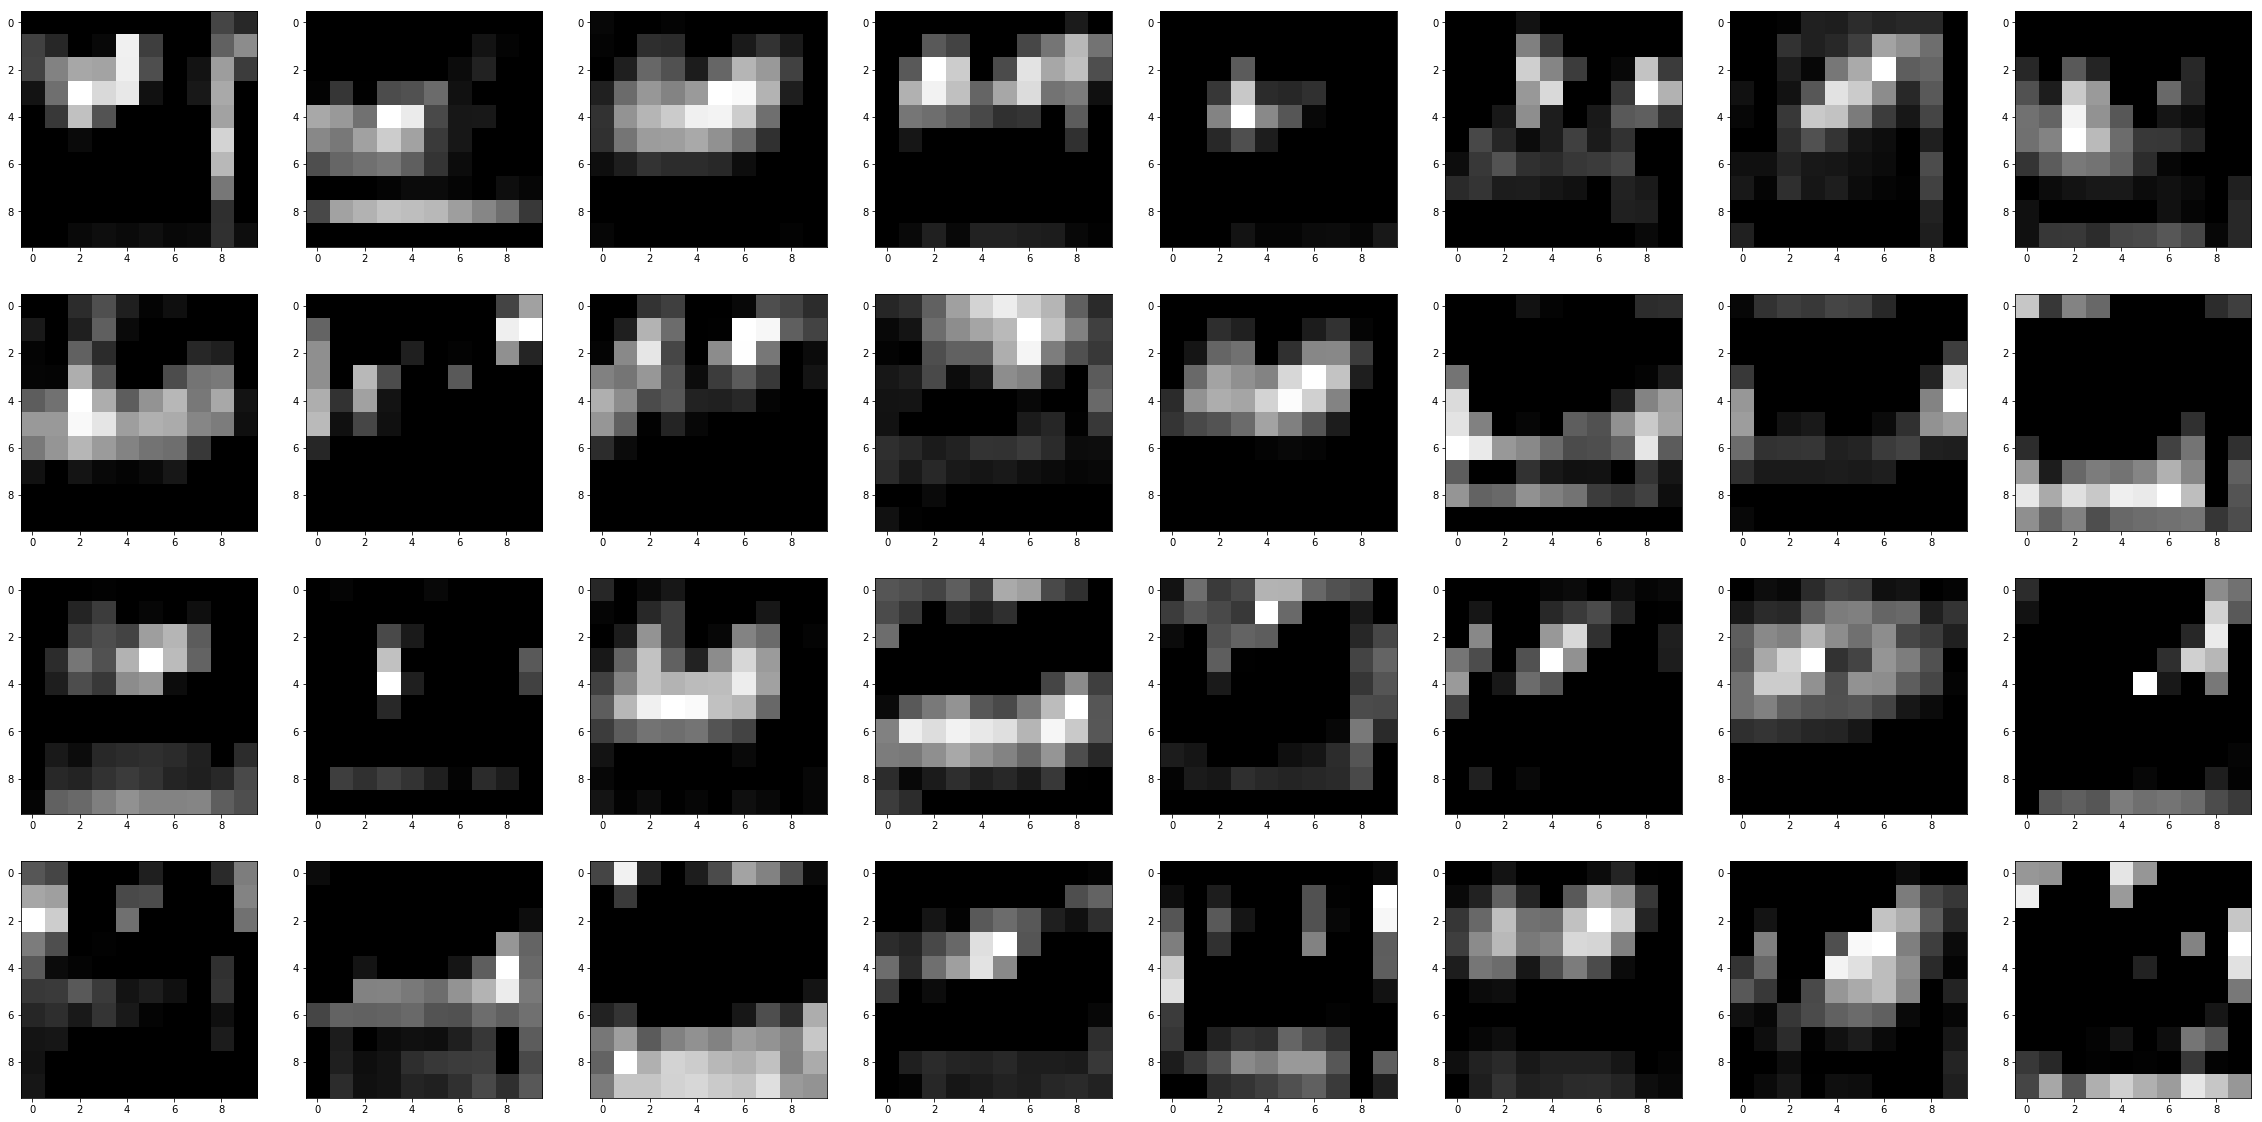

conv_pw_12_relu


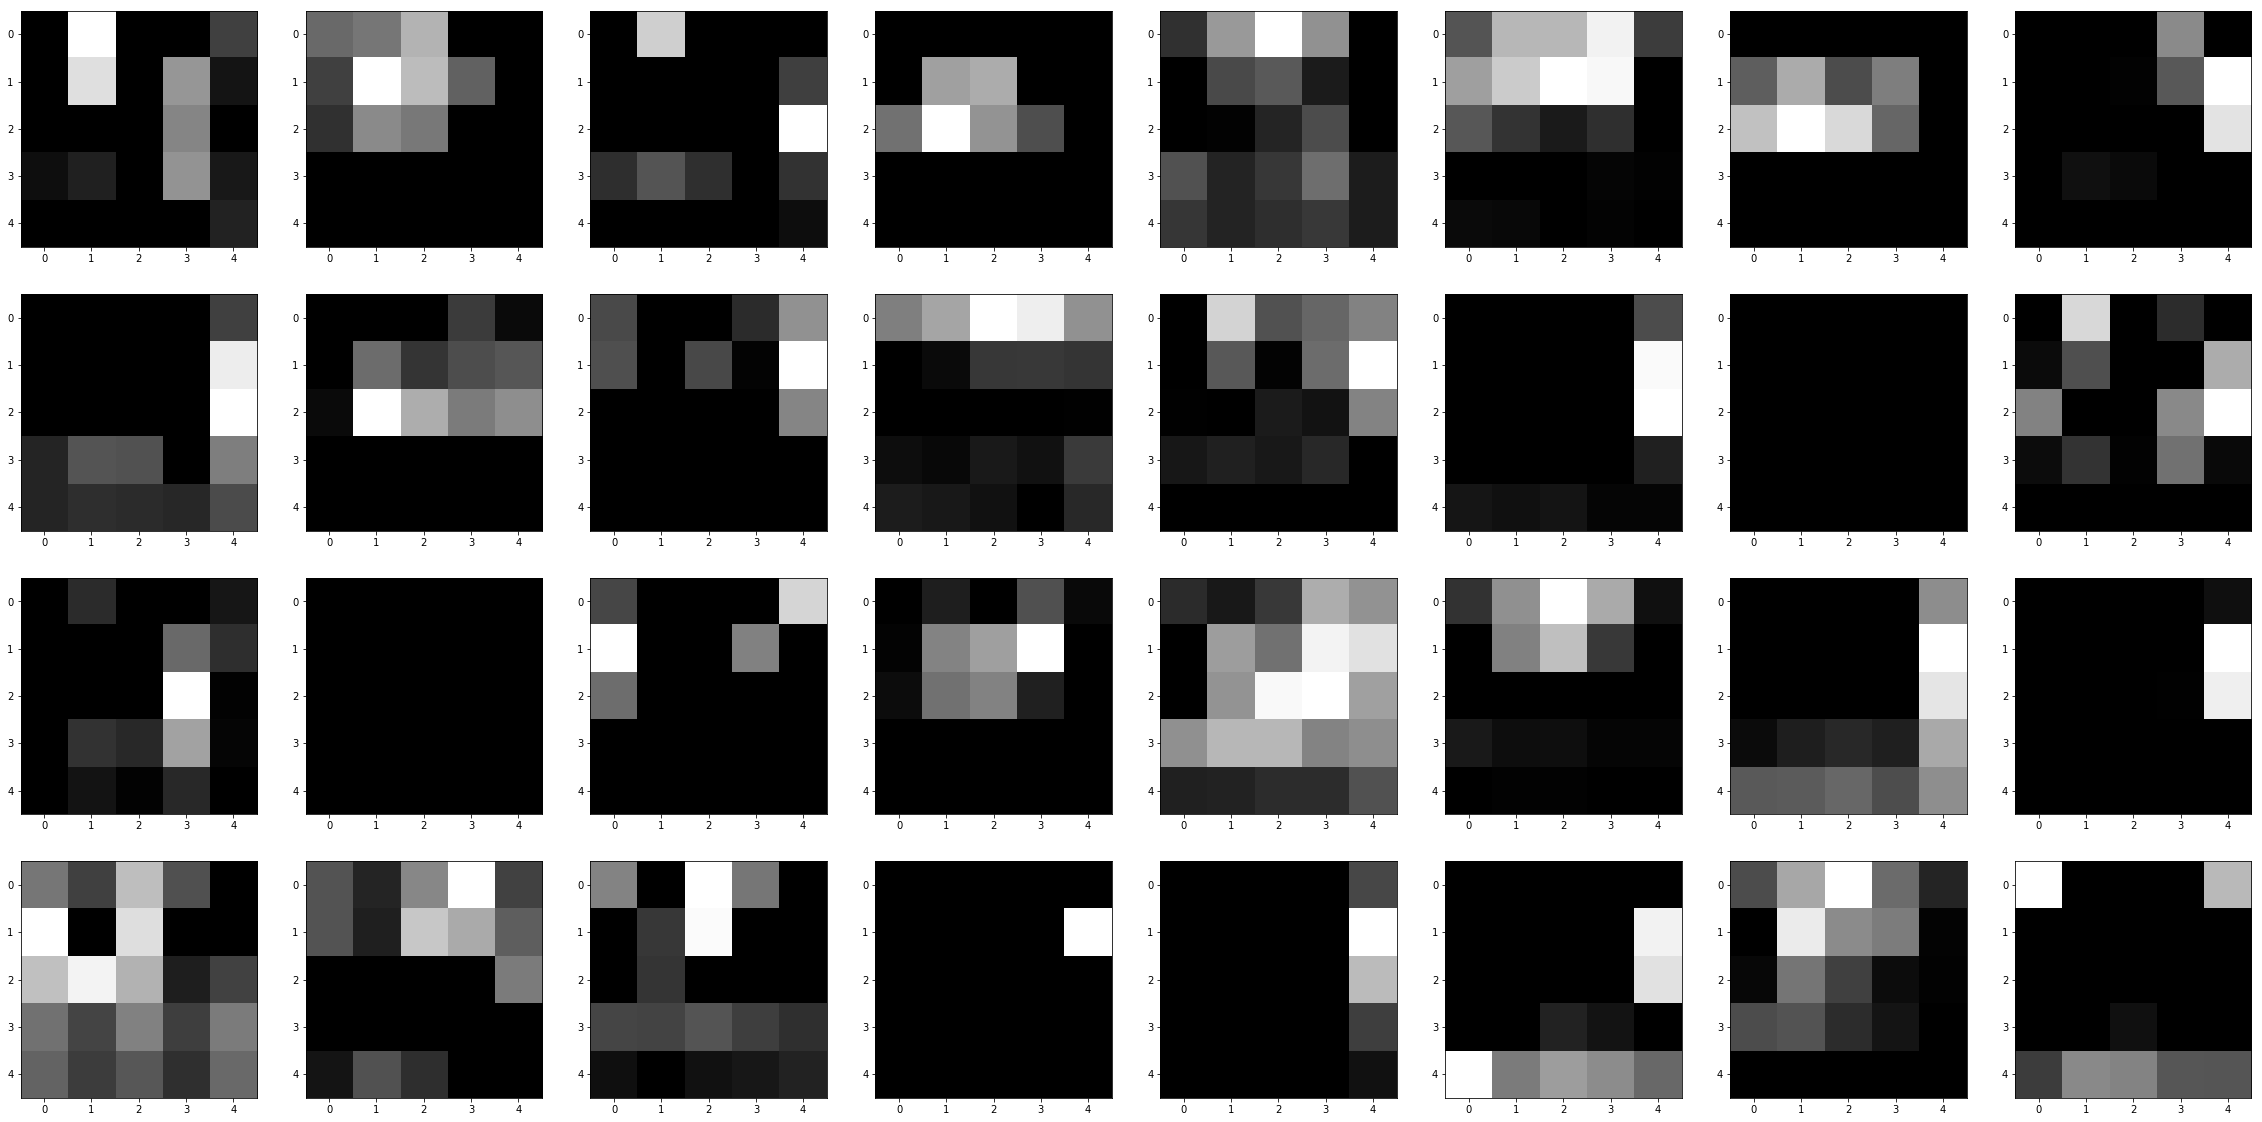

conv_pw_13_relu


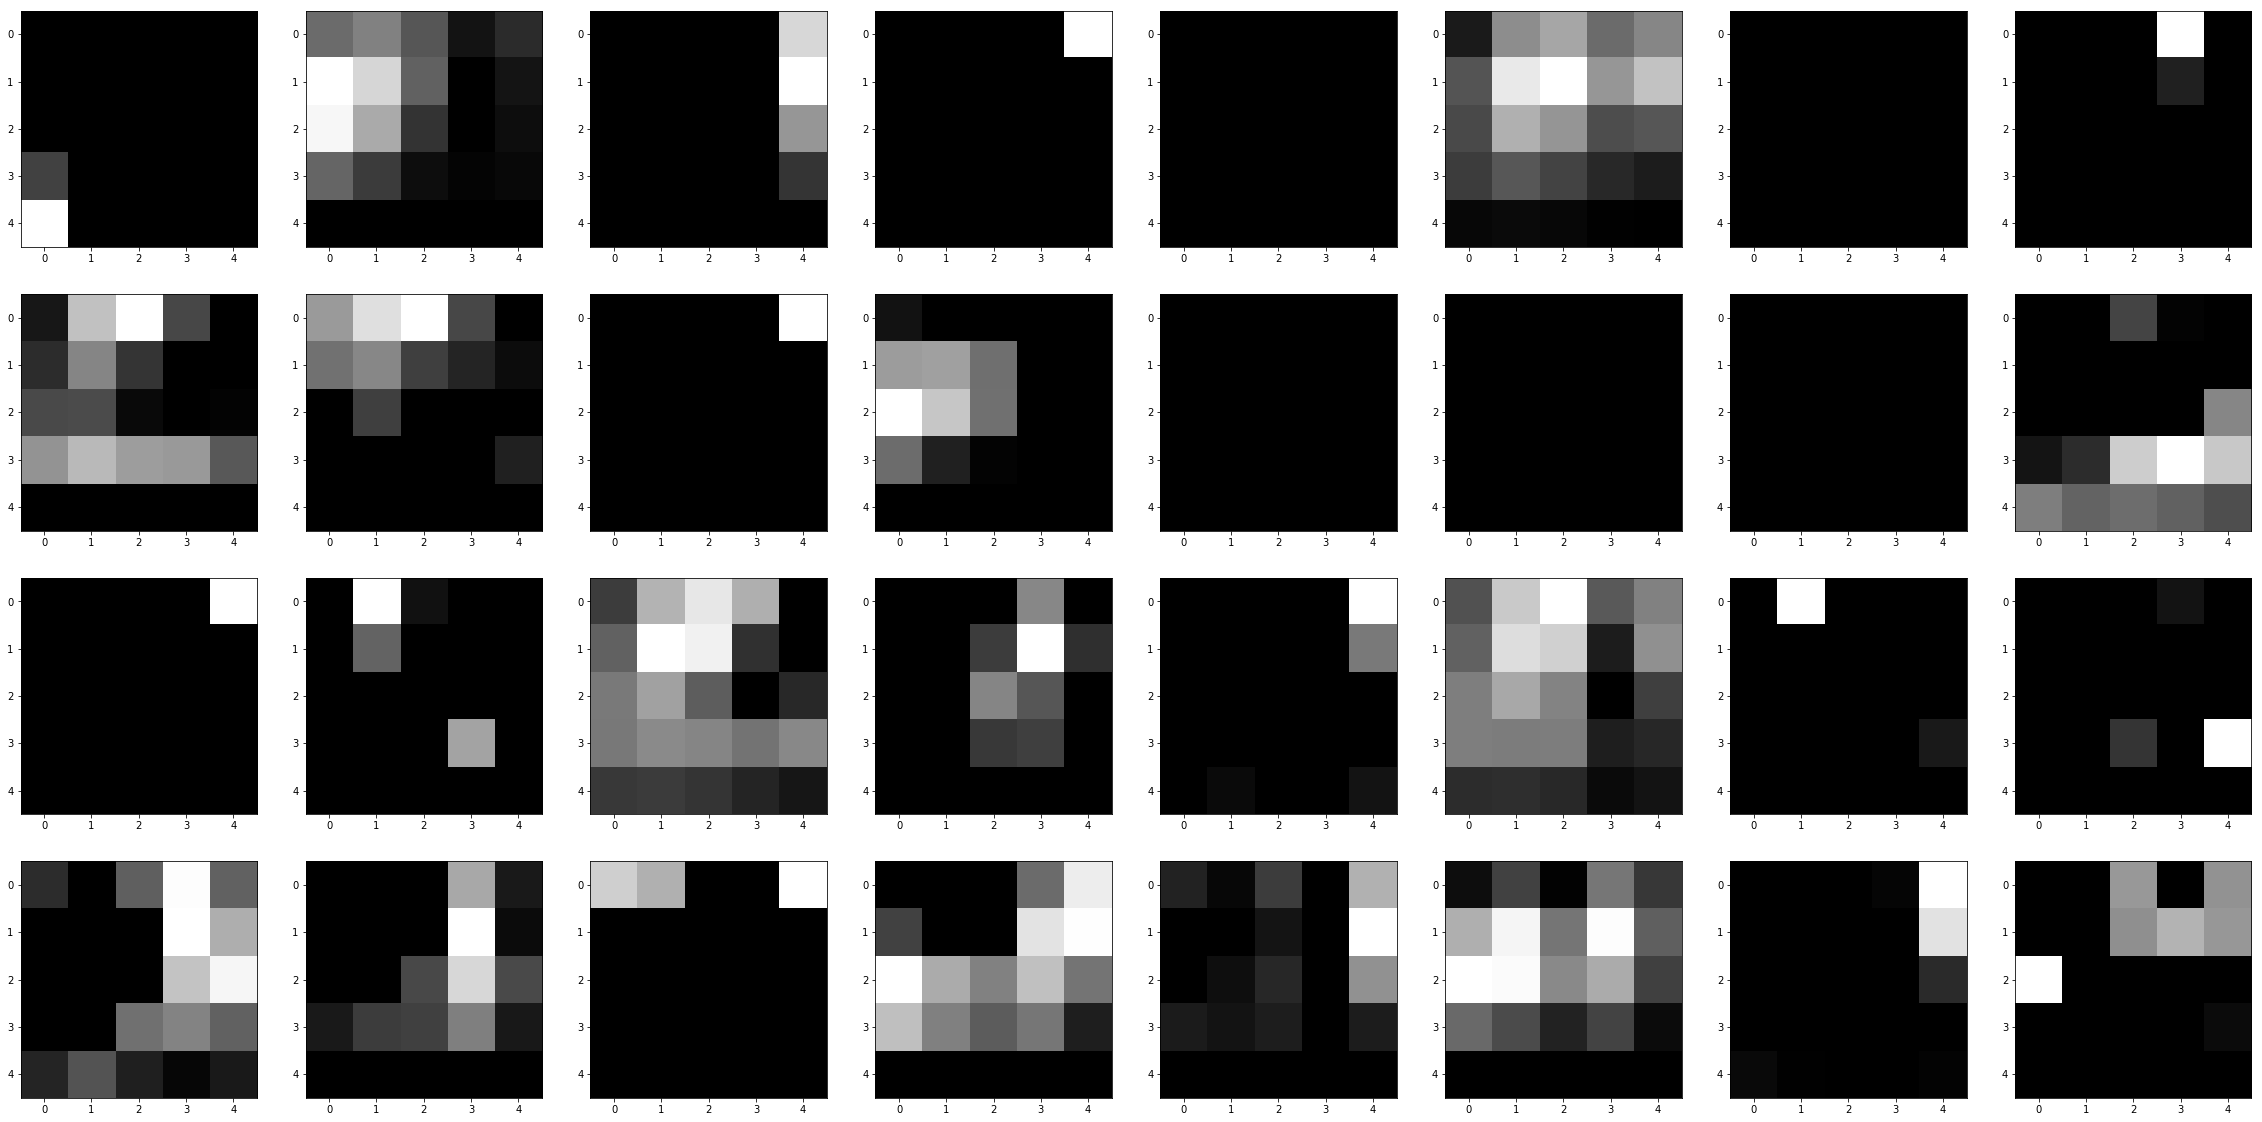

In [24]:
image = load_images(x_train[0], dim3=True)/256
for layer in oct_model.layers:
    if 'conv_pw_' in layer.name and 'relu' in layer.name:
        print(layer.name)
        show_features_at(layer.name, image)

The images above are the features of the model in the conv_pw_relu stages.

We can see there is very little visible features that are empty. This means that we can even add features to the model.

In [25]:
from keras import backend as K 

def attention_map(model, images):
    labels = model.predict(images).argmax(1)
    kernel = K.eval(model.get_layer('conv_preds').weights[0])[0, 0, :, :]
    feature = Model(model.input, model.get_layer('reshape_1').output).predict(images)[:,0,0,:]
    feature_map = Model(model.input, model.get_layer('conv_pw_13_relu').output).predict(images)
    for img in range(len(images)):
        for index in range(1024):
            feature_map[img][:,:,index] *= feature[img, index] * kernel[index, int(labels[img])]
    
    feature_map = feature_map.mean(axis=3)
    a_map = list()
    for img in range(len(images)):
        a_map.append(cv2.resize(normalize(feature_map[img]), (images.shape[2], images.shape[1])))
    return np.array(a_map)**3

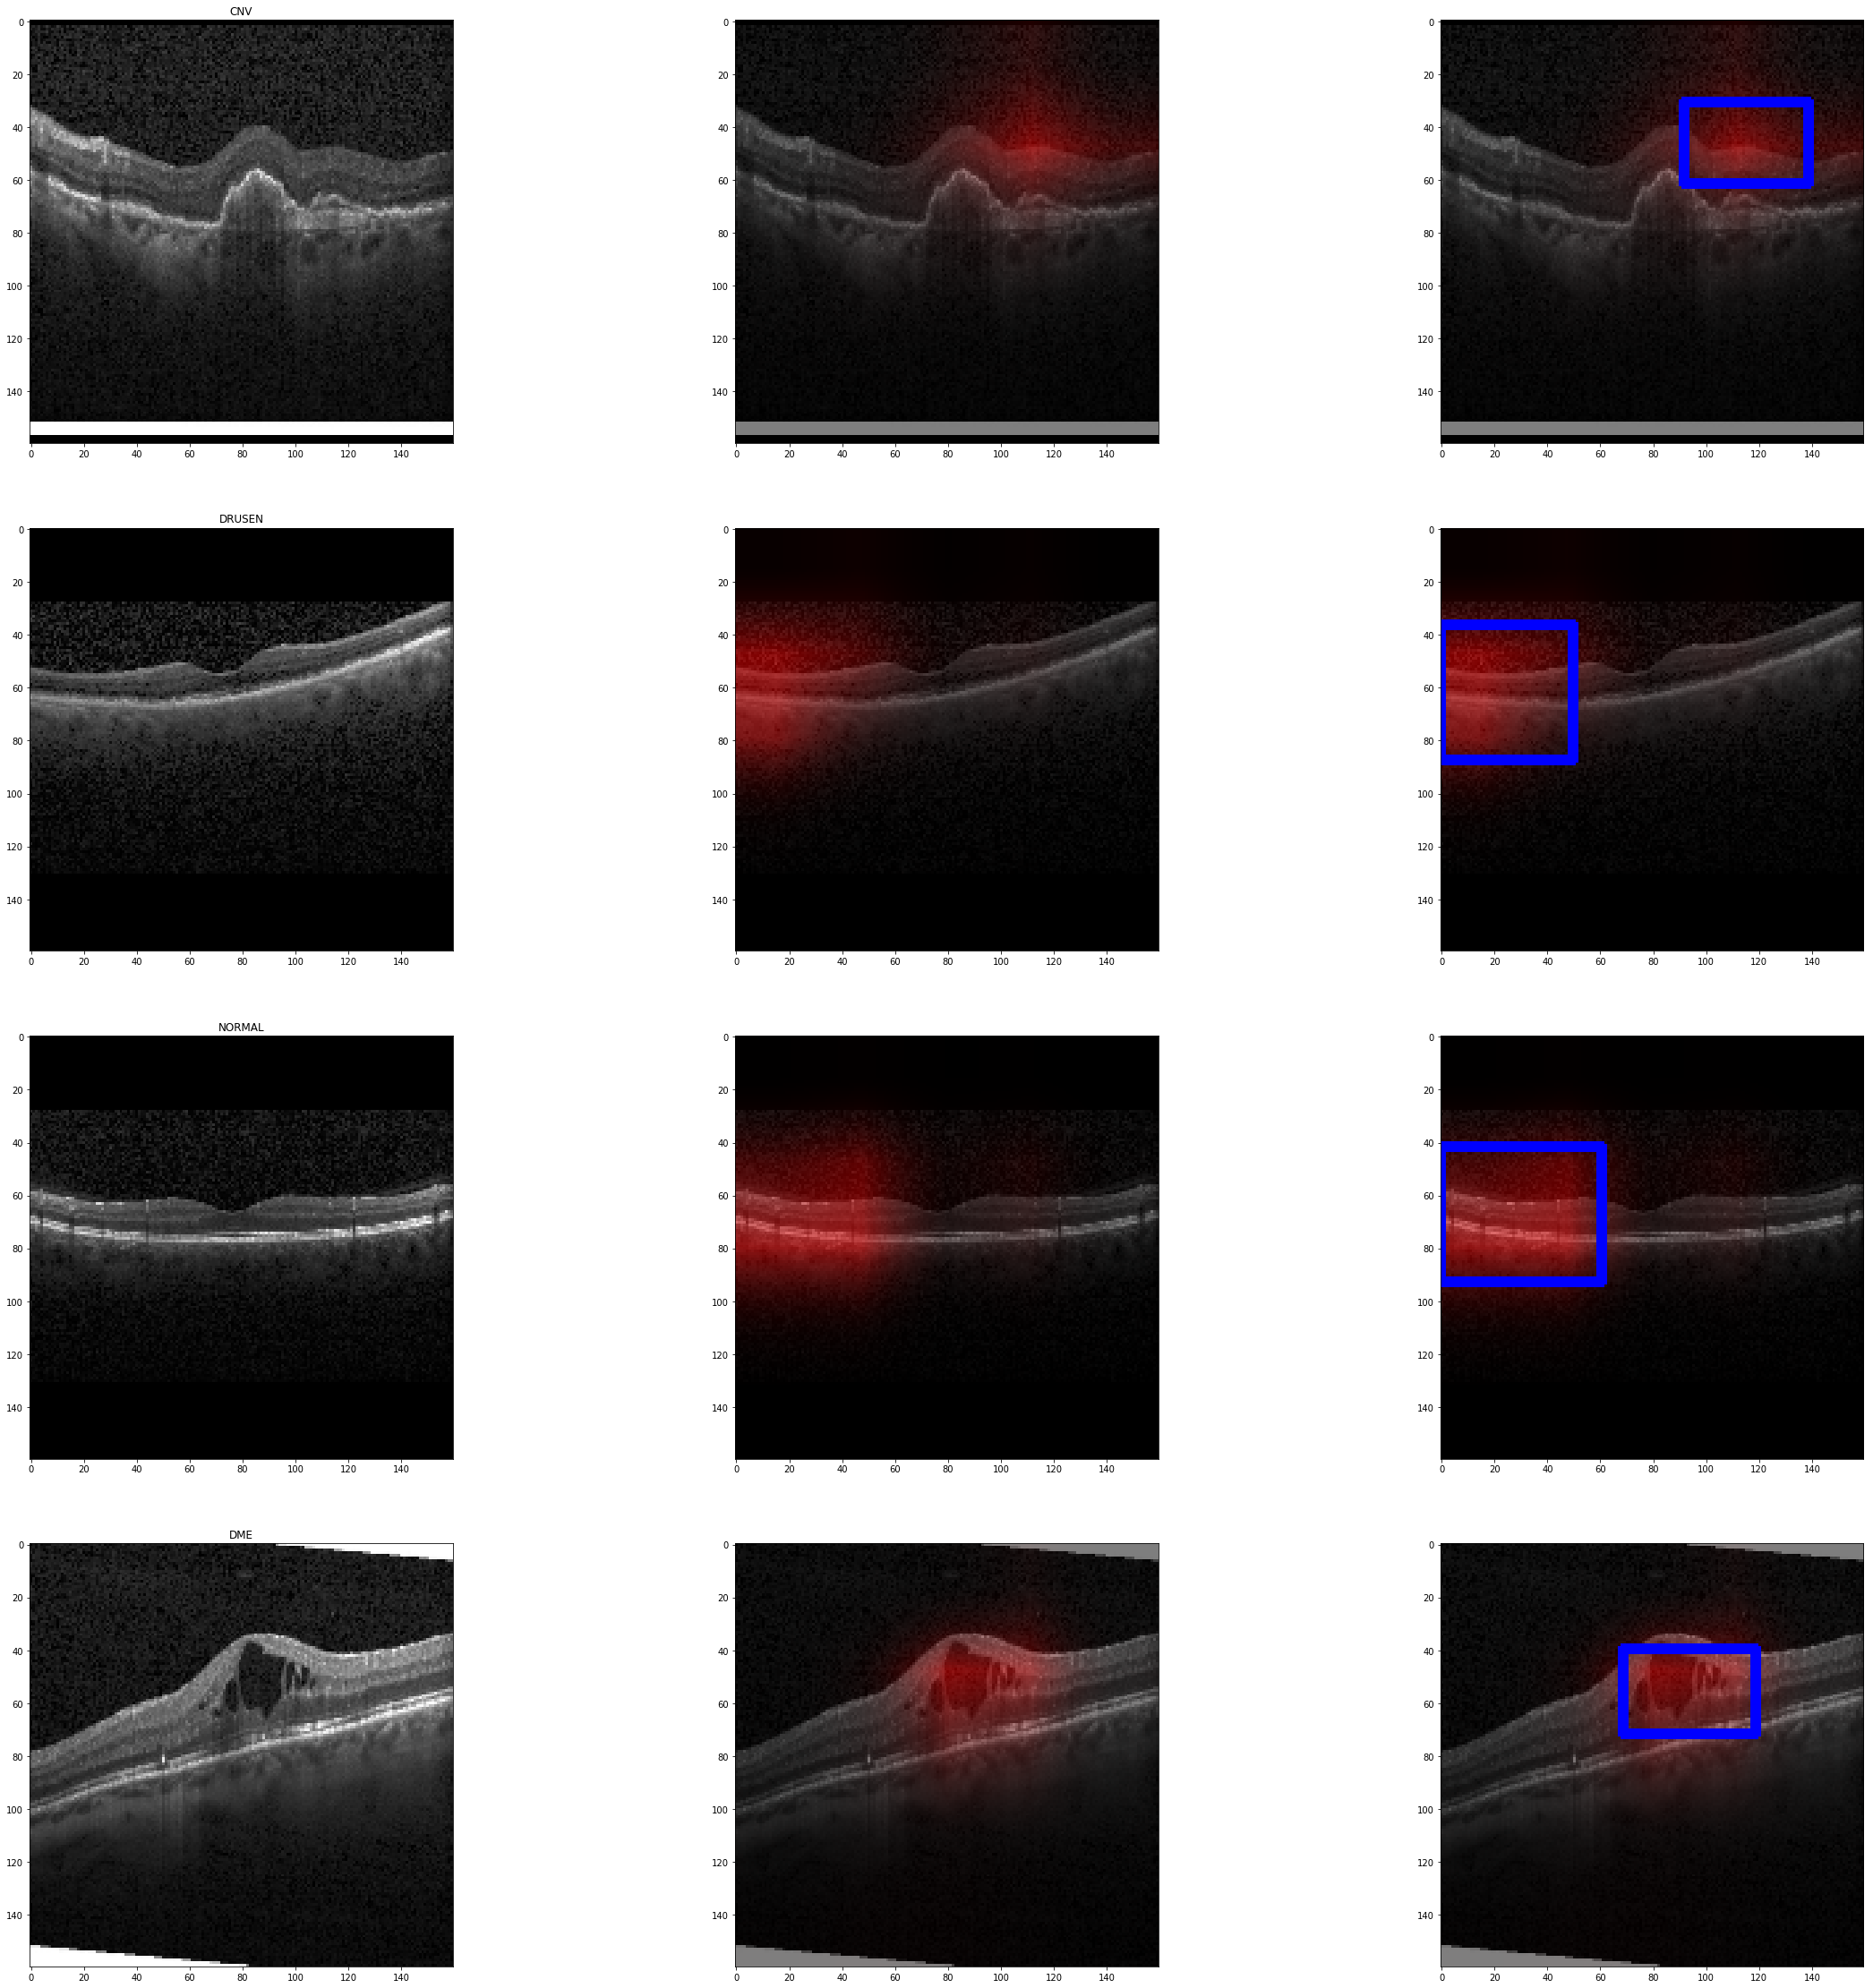

In [28]:
k = 4
x, y = next(data_generator(x_train, y_train, k))
plt.figure(figsize=[40,40])
a_map = attention_map(oct_model, x)

for ii in range(k):
    plt.subplot(k, 3, 3*ii + 1)
    plt.title(index2data[y[ii].argmax()])
    plt.imshow(x[ii][:,:,0], cmap='gray')
    
    tmp = int2float(cv2.cvtColor(float2int(x[ii][:,:,0]), cv2.COLOR_GRAY2RGB))/2
    tmp[:,:,0] +=a_map[ii]/2
    plt.subplot(k, 3, 3*ii + 2)
    plt.imshow(tmp)
    
    a_map[ii][a_map[ii]<0.5] = 0
    a_map[ii][a_map[ii]>=0.5] = 1
    _, contours, _ = cv2.findContours(a_map[ii].astype(int)*255, cv2.RETR_FLOODFILL,cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
        rx,ry,rw,rh = cv2.boundingRect(c)
        tmp = cv2.rectangle(tmp, (rx, ry), (rx+rw, ry+rh), (0,0,1), 2)
    plt.subplot(k, 3, 3*ii + 3)
    plt.imshow(tmp)

In the code above we extract from the last 5x5 layer an attention map by looking on their gradients.

with this map we can see Approximaly what area of the image activated the class that was predicted. 
With this we can start understanding the image. for examle in the DME image 
we can see its clearly marks the "hole" in the image.

But in the NORMAL image we can see its marks the area in the side and not a specific feature that can represent what is normal.

we can even see that with this method we can create a bbox that surrounds the disease in the image.
it is a not a prefct bbox but it gives a nice result.

In [29]:
def feature_extractor(paths):
    image2feature = dict()
    feature_extractor = Model(oct_model.input, oct_model.get_layer('global_average_pooling2d_1').output)
    jump = 10000
    for ii in range(0, len(paths), jump):
        upper_border = min(len(paths),ii+jump)
        features = feature_extractor.predict(load_images(paths[ii: upper_border], dim3=True))
        for jj in range(ii, upper_border):
            image2feature[paths[jj]] = features[jj%jump]
    return image2feature

Here we extract from each image all her features from the last layer. beacause it is a very
hard job we will do it ones and save it on the drive.

In [33]:
image2feature = feature_extractor(x_train)
np.save('image2feature.npy', image2feature)

In [34]:
image2feature = np.load('image2feature.npy').item()

In [35]:
from scipy.spatial import distance

def find_k_nearest_neighbors(image, k, image2feature):
    feature_extractor = Model(oct_model.input, oct_model.get_layer('global_average_pooling2d_1').output)
    image_feature = feature_extractor.predict(np.array([image]))
    
    dist = sorted(list(image2feature.items()), key=lambda x: distance.euclidean(x[1], image_feature))
    return [path[0] for path in dist[:k]]

def predict_by_k_nearest_neighbors(image, k, image2feature):
    neighbors = find_k_nearest_neighbors(image, k, image2feature)
    return Counter(y_train[np.isin(x_train, neighbors)].argmax(1)).most_common(1)[0][0]

with those methods we can find which images are similar to others and predict using this information.

In the examle below we show 10 most similliar to an image and predict using this inforamtion.

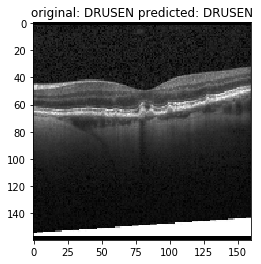

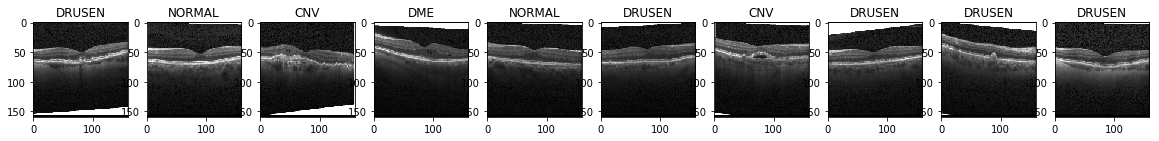

In [36]:
test = x_test[0]
image = load_images(test, dim3=True)
plt.imshow(image[:,:,0], cmap='gray')
plt.title('original: ' + index2data[y_test[x_test==test].argmax()] + ' predicted: ' 
          + index2data[predict_by_k_nearest_neighbors(image, 10, image2feature)])
plt.show()
k = 10
neighbors = find_k_nearest_neighbors(load_images(test, dim3=True), 10, image2feature)
plt.figure(figsize=[20,10])
for ii in range(k):
    plt.subplot(1,k,ii+1)
    plt.imshow(load_images(neighbors[ii]),cmap='gray')
    plt.title(index2data[y_train[x_train==neighbors[ii]].argmax()])
plt.show()

accuracy is: 0.449


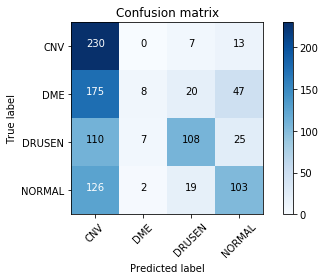

In [59]:
pred = [predict_by_k_nearest_neighbors(load_images(path, dim3=True), 3, image2feature) for path in x_test]
print('accuracy is:',accuracy_score(y_test.argmax(1), pred))
cm = confusion_matrix(y_test.argmax(1), pred)
plot_confusion_matrix(cm, classes)

We can see that the result are not very good. If we look closer we even see that they are biased to
classes that have more images, a lot of prediction to CNV and after this to NORMAL, DRUSEN and than DME.

Another thing that could make this not very good while the normal prediction is excellent is that there are 1024 features for each image, but some of them maybe have very small effect/weight on the class prediction compared to others features, but when we do the prediction with distance they all have the same weight.